In [1]:
# -------------------------------------------------------------------------------------------------
# LOAD REQUIRED LIBRARIES
# -------------------------------------------------------------------------------------------------
%matplotlib inline
import netCDF4
from distutils.util import strtobool
import pylab
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import platform
import numpy as np
import pyproj as pyproj
import datetime
import pdb
import time
import bmi.wrapper
# import pcrglobwb_203_30min_2way as pcrglobwb_bmi_v203
# from pcrglobwb_203_30min_2way import pcrglobwb_bmi
# from pcrglobwb_203_30min_2way import disclaimer
import model as pcrglobwb_bmi_v203
from model import pcrglobwb_bmi
from model import disclaimer
from coupling_PCR_FM_2way import coupling_functions
from coupling_PCR_FM_2way import model_functions
from coupling_PCR_FM_2way import utils
from coupling_PCR_FM_2way import configuration
%config Application.log_level="INFO"

/home/jannis/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# -------------------------------------------------------------------------------------------------
# IMPORT MODEL SETTINGS FROM INI-FILE/SET-FILE
# -------------------------------------------------------------------------------------------------

arg = r'/home/jannis/PhD/scripts/2WAY/2way_AMA_1d2d_codeDevelopment.ini'

config = configuration.Configuration()
#config.parse_configuration_file(sys.argv[1])
config.parse_configuration_file(arg)

In [3]:
# -------------------------------------------------------------------------------------------------
# SPECIFY MODEL SETTINGS
# -------------------------------------------------------------------------------------------------

model_type = config.model_type['model_type']

use_2way = strtobool(config.general_settings['2way coupling'])

latlon = strtobool(config.general_settings['latlon'])
if latlon == False:
    inProj  = pyproj.Proj(init=config.model_settings['model_projection'])

use_Fluxes = strtobool(config.general_settings['use_Fluxes'])

use_RFS = strtobool(config.general_settings['use_RFS'])
if use_2way == True:
    use_RFS = True

verbose = strtobool(config.general_settings['verbose'])

couple_channelStorage = True

In [4]:
# -------------------------------------------------------------------------------------------------
# SPECIFY NUMERICAL SETTINGS
# -------------------------------------------------------------------------------------------------

nr_model_timesteps                    = int(config.numerical_settings['number_of_timesteps'])
update_step                           = int(config.numerical_settings['update_step'])

secPerDay                             = 86400.
end_time 							  = nr_model_timesteps * secPerDay
fraction_timestep 					  = secPerDay / update_step

threshold_inundated_depth             = float(config.numerical_settings['threshold_inundated_depth'])

# other
missing_value_landmask                = 255
missing_value_pcr                     = -999

In [112]:
nr_model_timesteps

730

In [5]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO MODELS
# -------------------------------------------------------------------------------------------------

# hydrodynamics
model_dir       	= config.model_settings['model_dir']
model_file      	= config.model_settings['model_file']
model_proj			= config.model_settings['model_projection']

# hydrology
config_pcr       	=  config.PCR_settings['config_pcr']
configPCR           = configuration.Configuration()
configPCR.parse_configuration_file(config_pcr )
inputDIR 			= configPCR.globalOptions['inputDir']
clone_pcr 			= os.path.join(inputDIR, configPCR.globalOptions['cloneMap'])
landmask_pcr 		= os.path.join(inputDIR, configPCR.globalOptions['landmask'])
LDD                 = os.path.join(inputDIR, configPCR.routingOptions['lddMap'])

In [6]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO .SO / .DLL FILES
# -------------------------------------------------------------------------------------------------

# these may be changed according to personal file and folder structure
if model_type == 'DFM':
    model_path = '/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so'

elif model_type == 'LFP':
    model_path = '/home/jannis/Programmes/LISFLOODFP/lisflood-bmi-v5.9/liblisflood.so'

else:
    sys.exit('\nno adequate model defined in configuration file - define either DFM or LFP!\n')

In [7]:
# -------------------------------------------------------------------------------------------------
# INITIALIZE AND SPIN-UP PCR-GLOBWB
# -------------------------------------------------------------------------------------------------

# initiate logging and define folder for verbose-output
verbose_folder = model_functions.write2log(model_dir, model_file, latlon, use_2way, use_Fluxes, use_RFS, use_floodplain_infiltration_factor=False, adjust_initial_groundwater=False, verbose=False, moment='start')
print 'Model Start-Time: ', datetime.datetime.now()
print ''

# initiate PCR-GLOBWB
hydrologicModel = pcrglobwb_bmi_v203.pcrglobwb_bmi.pcrglobwbBMI()
hydrologicModel.initialize(config_pcr)
print '\n>>> PCR Initialized <<<\n'

# spin-up PCR-GLOBWB
hydrologicModel.spinup()

2018-02-20 13:19:27,560 model.disclaimer INFO 

 PCR-GLOBWB (PCRaster Global Water Balance) Global Hydrological Model                       

 Copyright (C) 2016, Ludovicus P. H. (Rens) van Beek, Edwin H. Sutanudjaja, Yoshihide Wada, 
 Joyce H. C. Bosmans, Niels Drost, Inge E. M. de Graaf, Kor de Jong, Patricia Lopez Lopez,  
 Stefanie Pessenteiner, Oliver Schmitz, Menno W. Straatsma, Niko Wanders, Dominik Wisser,   
 and Marc F. P. Bierkens,                                                                   
 Faculty of Geosciences, Utrecht University, Utrecht, The Netherlands                       

 This program comes with ABSOLUTELY NO WARRANTY                                             
 This is free software, and you are welcome to redistribute it under certain conditions     
 See the LICENSE file for more details                                                      


2018-02-20 13:19:27,561 model.configuration INFO Model run started at 2018-02-20 13:19:27.528756
2018-02-20 13:


##############################
### MODEL COUPLING STARTED ###
##############################

model file chosen:  AMA_DFM_2km_1D2D.mdu
2way coupling activated:  True
lat-lon on:  True
fluxes on:  True
RFS on:  True
use floodplain infiltration factor:  False
adjust initial groundwater:  False
verbose mode on:  False

Model Start-Time:  2018-02-20 13:19:27.528279



2018-02-20 13:19:28,036 model.meteo INFO No forcing downscaling is implemented.
2018-02-20 13:19:28,197 model.landSurface INFO Irrigation is NOT included/considered in this run.
2018-02-20 13:19:28,199 model.landSurface INFO Domestic water demand is NOT included in the calculation.
2018-02-20 13:19:28,199 model.landSurface INFO Industry water demand is NOT included in the calculation.
2018-02-20 13:19:28,200 model.landSurface INFO Livestock water demand is NOT included in the calculation.
2018-02-20 13:19:28,201 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-02-20 13:19:28,206 model.landSurface INFO Monthly desalination water is NOT included.
2018-02-20 13:19:28,207 model.landSurface INFO If there is any, water demand is satisfied by local source only.
2018-02-20 13:19:30,518 model.landSurface INFO Using the default set of soil and topo parameters as defined in the landSurfa


>>> PCR Initialized <<<



2018-02-20 13:19:38,347 model.meteo INFO No forcing downscaling is implemented.
2018-02-20 13:19:38,494 model.landSurface INFO Irrigation is NOT included/considered in this run.
2018-02-20 13:19:38,503 model.landSurface INFO Domestic water demand is NOT included in the calculation.
2018-02-20 13:19:38,504 model.landSurface INFO Industry water demand is NOT included in the calculation.
2018-02-20 13:19:38,505 model.landSurface INFO Livestock water demand is NOT included in the calculation.
2018-02-20 13:19:38,506 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-02-20 13:19:38,512 model.landSurface INFO Monthly desalination water is NOT included.
2018-02-20 13:19:38,513 model.landSurface INFO If there is any, water demand is satisfied by local source only.
2018-02-20 13:19:40,835 model.landSurface INFO Using the default set of soil and topo parameters as defined in the landSurfa

2018-02-20 13:19:52,488 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-20 13:19:52,570 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-20 13:19:52,722 model.groundwater INFO Updating groundwater
2018-02-20 13:19:52,728 model.routing INFO routing in progress
2018-02-20 13:19:52,732 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:19:52,744 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:19:52,763 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:19:52,781 model.routing INFO sub-daily t

2018-02-20 13:19:55,367 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-04 is NOT available. The date 2000-1-4 is used.

2018-02-20 13:19:55,433 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-04 is NOT available. The date 2000-1-4 is used.

2018-02-20 13:19:55,536 model.groundwater INFO Updating groundwater
2018-02-20 13:19:55,542 model.routing INFO routing in progress
2018-02-20 13:19:55,546 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:19:55,559 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:19:55,573 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:19:55,592 model.routing INFO sub-daily t

2018-02-20 13:19:57,959 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-06 is NOT available. The date 2000-1-6 is used.

2018-02-20 13:19:58,045 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-06 is NOT available. The date 2000-1-6 is used.

2018-02-20 13:19:58,177 model.groundwater INFO Updating groundwater
2018-02-20 13:19:58,183 model.routing INFO routing in progress
2018-02-20 13:19:58,186 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:19:58,197 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:19:58,215 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:19:58,233 model.routing INFO sub-daily t

2018-02-20 13:20:00,636 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-02-20 13:20:00,735 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-02-20 13:20:00,876 model.groundwater INFO Updating groundwater
2018-02-20 13:20:00,888 model.routing INFO routing in progress
2018-02-20 13:20:00,893 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:00,907 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:00,929 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:00,951 model.routing INFO sub-daily t

2018-02-20 13:20:03,375 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-20 13:20:03,450 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-20 13:20:03,581 model.groundwater INFO Updating groundwater
2018-02-20 13:20:03,588 model.routing INFO routing in progress
2018-02-20 13:20:03,591 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:03,603 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:03,622 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:03,641 model.routing INFO sub-daily

2018-02-20 13:20:05,981 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-12 is NOT available. The date 2000-1-12 is used.

2018-02-20 13:20:06,060 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-12 is NOT available. The date 2000-1-12 is used.

2018-02-20 13:20:06,197 model.groundwater INFO Updating groundwater
2018-02-20 13:20:06,203 model.routing INFO routing in progress
2018-02-20 13:20:06,206 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:06,218 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:06,236 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:06,255 model.routing INFO sub-daily

2018-02-20 13:20:08,587 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-14 is NOT available. The date 2000-1-14 is used.

2018-02-20 13:20:08,666 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-14 is NOT available. The date 2000-1-14 is used.

2018-02-20 13:20:08,801 model.groundwater INFO Updating groundwater
2018-02-20 13:20:08,809 model.routing INFO routing in progress
2018-02-20 13:20:08,812 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:08,823 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:08,842 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:08,861 model.routing INFO sub-daily

2018-02-20 13:20:11,246 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-16 is NOT available. The date 2000-1-16 is used.

2018-02-20 13:20:11,336 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-16 is NOT available. The date 2000-1-16 is used.

2018-02-20 13:20:11,485 model.groundwater INFO Updating groundwater
2018-02-20 13:20:11,491 model.routing INFO routing in progress
2018-02-20 13:20:11,494 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:11,506 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:11,525 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:11,544 model.routing INFO sub-daily

2018-02-20 13:20:14,049 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-18 is NOT available. The date 2000-1-18 is used.

2018-02-20 13:20:14,124 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-18 is NOT available. The date 2000-1-18 is used.

2018-02-20 13:20:14,263 model.groundwater INFO Updating groundwater
2018-02-20 13:20:14,272 model.routing INFO routing in progress
2018-02-20 13:20:14,278 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:14,290 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:14,311 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:14,332 model.routing INFO sub-daily

2018-02-20 13:20:16,702 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-20 is NOT available. The date 2000-1-20 is used.

2018-02-20 13:20:16,788 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-20 is NOT available. The date 2000-1-20 is used.

2018-02-20 13:20:16,920 model.groundwater INFO Updating groundwater
2018-02-20 13:20:16,926 model.routing INFO routing in progress
2018-02-20 13:20:16,930 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:16,941 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:16,960 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:16,977 model.routing INFO sub-daily

2018-02-20 13:20:19,393 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-22 is NOT available. The date 2000-1-22 is used.

2018-02-20 13:20:19,479 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-22 is NOT available. The date 2000-1-22 is used.

2018-02-20 13:20:19,620 model.groundwater INFO Updating groundwater
2018-02-20 13:20:19,628 model.routing INFO routing in progress
2018-02-20 13:20:19,633 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:19,646 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:19,667 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:19,688 model.routing INFO sub-daily

2018-02-20 13:20:22,075 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-24 is NOT available. The date 2000-1-24 is used.

2018-02-20 13:20:22,155 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-24 is NOT available. The date 2000-1-24 is used.

2018-02-20 13:20:22,302 model.groundwater INFO Updating groundwater
2018-02-20 13:20:22,309 model.routing INFO routing in progress
2018-02-20 13:20:22,312 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:22,324 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:22,344 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:22,364 model.routing INFO sub-daily

2018-02-20 13:20:24,790 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-26 is NOT available. The date 2000-1-26 is used.

2018-02-20 13:20:24,888 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-26 is NOT available. The date 2000-1-26 is used.

2018-02-20 13:20:25,041 model.groundwater INFO Updating groundwater
2018-02-20 13:20:25,049 model.routing INFO routing in progress
2018-02-20 13:20:25,055 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:25,068 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:25,089 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:25,108 model.routing INFO sub-daily

2018-02-20 13:20:27,619 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-28 is NOT available. The date 2000-1-28 is used.

2018-02-20 13:20:27,696 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-28 is NOT available. The date 2000-1-28 is used.

2018-02-20 13:20:27,831 model.groundwater INFO Updating groundwater
2018-02-20 13:20:27,836 model.routing INFO routing in progress
2018-02-20 13:20:27,839 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:27,851 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:27,867 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:27,883 model.routing INFO sub-daily

2018-02-20 13:20:30,271 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-30 is NOT available. The date 2000-1-30 is used.

2018-02-20 13:20:30,365 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-30 is NOT available. The date 2000-1-30 is used.

2018-02-20 13:20:30,505 model.groundwater INFO Updating groundwater
2018-02-20 13:20:30,511 model.routing INFO routing in progress
2018-02-20 13:20:30,516 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:30,527 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:30,544 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:30,558 model.routing INFO sub-daily

2018-02-20 13:20:32,996 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-01 is NOT available. The date 2000-2-1 is used.

2018-02-20 13:20:33,090 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-01 is NOT available. The date 2000-2-1 is used.

2018-02-20 13:20:33,252 model.groundwater INFO Updating groundwater
2018-02-20 13:20:33,259 model.routing INFO routing in progress
2018-02-20 13:20:33,263 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:33,286 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:33,378 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:33,474 model.routing INFO sub-daily t

2018-02-20 13:20:37,571 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-03 is NOT available. The date 2000-2-3 is used.

2018-02-20 13:20:37,662 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-03 is NOT available. The date 2000-2-3 is used.

2018-02-20 13:20:37,799 model.groundwater INFO Updating groundwater
2018-02-20 13:20:37,805 model.routing INFO routing in progress
2018-02-20 13:20:37,808 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:37,819 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:37,838 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:37,856 model.routing INFO sub-daily t

2018-02-20 13:20:40,238 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-05 is NOT available. The date 2000-2-5 is used.

2018-02-20 13:20:40,327 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-05 is NOT available. The date 2000-2-5 is used.

2018-02-20 13:20:40,463 model.groundwater INFO Updating groundwater
2018-02-20 13:20:40,470 model.routing INFO routing in progress
2018-02-20 13:20:40,475 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:40,488 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:40,508 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:40,529 model.routing INFO sub-daily t

2018-02-20 13:20:42,802 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-07 is NOT available. The date 2000-2-7 is used.

2018-02-20 13:20:42,874 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-07 is NOT available. The date 2000-2-7 is used.

2018-02-20 13:20:43,003 model.groundwater INFO Updating groundwater
2018-02-20 13:20:43,009 model.routing INFO routing in progress
2018-02-20 13:20:43,013 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:43,025 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:43,043 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:43,062 model.routing INFO sub-daily t

2018-02-20 13:20:45,436 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-09 is NOT available. The date 2000-2-9 is used.

2018-02-20 13:20:45,511 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-09 is NOT available. The date 2000-2-9 is used.

2018-02-20 13:20:45,641 model.groundwater INFO Updating groundwater
2018-02-20 13:20:45,646 model.routing INFO routing in progress
2018-02-20 13:20:45,649 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:45,662 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:45,678 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:45,697 model.routing INFO sub-daily t

2018-02-20 13:20:48,138 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-11 is NOT available. The date 2000-2-11 is used.

2018-02-20 13:20:48,215 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-11 is NOT available. The date 2000-2-11 is used.

2018-02-20 13:20:48,348 model.groundwater INFO Updating groundwater
2018-02-20 13:20:48,354 model.routing INFO routing in progress
2018-02-20 13:20:48,357 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:48,369 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:48,387 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:48,405 model.routing INFO sub-daily

2018-02-20 13:20:50,772 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-13 is NOT available. The date 2000-2-13 is used.

2018-02-20 13:20:50,833 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-13 is NOT available. The date 2000-2-13 is used.

2018-02-20 13:20:50,961 model.groundwater INFO Updating groundwater
2018-02-20 13:20:50,967 model.routing INFO routing in progress
2018-02-20 13:20:50,970 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:50,982 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:51,001 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:51,019 model.routing INFO sub-daily

2018-02-20 13:20:53,647 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-15 is NOT available. The date 2000-2-15 is used.

2018-02-20 13:20:53,735 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-15 is NOT available. The date 2000-2-15 is used.

2018-02-20 13:20:53,878 model.groundwater INFO Updating groundwater
2018-02-20 13:20:53,888 model.routing INFO routing in progress
2018-02-20 13:20:53,894 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:53,906 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:53,925 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:53,944 model.routing INFO sub-daily

2018-02-20 13:20:56,371 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-17 is NOT available. The date 2000-2-17 is used.

2018-02-20 13:20:56,454 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-17 is NOT available. The date 2000-2-17 is used.

2018-02-20 13:20:56,595 model.groundwater INFO Updating groundwater
2018-02-20 13:20:56,601 model.routing INFO routing in progress
2018-02-20 13:20:56,605 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:56,616 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:56,636 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:56,655 model.routing INFO sub-daily

2018-02-20 13:20:59,041 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-19 is NOT available. The date 2000-2-19 is used.

2018-02-20 13:20:59,119 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-19 is NOT available. The date 2000-2-19 is used.

2018-02-20 13:20:59,257 model.groundwater INFO Updating groundwater
2018-02-20 13:20:59,263 model.routing INFO routing in progress
2018-02-20 13:20:59,266 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:20:59,277 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:20:59,295 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:20:59,314 model.routing INFO sub-daily

2018-02-20 13:21:01,752 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-21 is NOT available. The date 2000-2-21 is used.

2018-02-20 13:21:01,831 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-21 is NOT available. The date 2000-2-21 is used.

2018-02-20 13:21:01,969 model.groundwater INFO Updating groundwater
2018-02-20 13:21:01,977 model.routing INFO routing in progress
2018-02-20 13:21:01,982 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:01,996 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:02,018 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:02,039 model.routing INFO sub-daily

2018-02-20 13:21:04,479 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-23 is NOT available. The date 2000-2-23 is used.

2018-02-20 13:21:04,561 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-23 is NOT available. The date 2000-2-23 is used.

2018-02-20 13:21:04,701 model.groundwater INFO Updating groundwater
2018-02-20 13:21:04,713 model.routing INFO routing in progress
2018-02-20 13:21:04,716 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:04,731 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:04,750 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:04,768 model.routing INFO sub-daily

2018-02-20 13:21:07,133 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-25 is NOT available. The date 2000-2-25 is used.

2018-02-20 13:21:07,215 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-25 is NOT available. The date 2000-2-25 is used.

2018-02-20 13:21:07,356 model.groundwater INFO Updating groundwater
2018-02-20 13:21:07,363 model.routing INFO routing in progress
2018-02-20 13:21:07,369 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:07,382 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:07,403 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:07,424 model.routing INFO sub-daily

2018-02-20 13:21:09,878 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-27 is NOT available. The date 2000-2-27 is used.

2018-02-20 13:21:09,964 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-27 is NOT available. The date 2000-2-27 is used.

2018-02-20 13:21:10,116 model.groundwater INFO Updating groundwater
2018-02-20 13:21:10,122 model.routing INFO routing in progress
2018-02-20 13:21:10,126 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:10,137 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:10,156 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:10,176 model.routing INFO sub-daily

2018-02-20 13:21:12,545 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-29 is NOT available. The date 2000-2-29 is used.

2018-02-20 13:21:12,620 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-29 is NOT available. The date 2000-2-29 is used.

2018-02-20 13:21:12,760 model.groundwater INFO Updating groundwater
2018-02-20 13:21:12,765 model.routing INFO routing in progress
2018-02-20 13:21:12,769 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:12,789 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:12,808 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:12,827 model.routing INFO sub-daily

2018-02-20 13:21:17,149 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-02 is NOT available. The date 2000-3-2 is used.

2018-02-20 13:21:17,227 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-02 is NOT available. The date 2000-3-2 is used.

2018-02-20 13:21:17,357 model.groundwater INFO Updating groundwater
2018-02-20 13:21:17,362 model.routing INFO routing in progress
2018-02-20 13:21:17,366 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:17,377 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:17,394 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:17,412 model.routing INFO sub-daily t

2018-02-20 13:21:19,796 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-04 is NOT available. The date 2000-3-4 is used.

2018-02-20 13:21:19,870 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-04 is NOT available. The date 2000-3-4 is used.

2018-02-20 13:21:20,003 model.groundwater INFO Updating groundwater
2018-02-20 13:21:20,009 model.routing INFO routing in progress
2018-02-20 13:21:20,012 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:20,023 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:20,045 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:20,067 model.routing INFO sub-daily t

2018-02-20 13:21:22,453 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-06 is NOT available. The date 2000-3-6 is used.

2018-02-20 13:21:22,540 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-06 is NOT available. The date 2000-3-6 is used.

2018-02-20 13:21:22,681 model.groundwater INFO Updating groundwater
2018-02-20 13:21:22,688 model.routing INFO routing in progress
2018-02-20 13:21:22,691 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:22,702 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:22,720 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:22,741 model.routing INFO sub-daily t

2018-02-20 13:21:25,221 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-08 is NOT available. The date 2000-3-8 is used.

2018-02-20 13:21:25,283 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-08 is NOT available. The date 2000-3-8 is used.

2018-02-20 13:21:25,403 model.groundwater INFO Updating groundwater
2018-02-20 13:21:25,409 model.routing INFO routing in progress
2018-02-20 13:21:25,413 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:25,425 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:25,444 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:25,462 model.routing INFO sub-daily t

2018-02-20 13:21:27,952 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-10 is NOT available. The date 2000-3-10 is used.

2018-02-20 13:21:28,032 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-10 is NOT available. The date 2000-3-10 is used.

2018-02-20 13:21:28,170 model.groundwater INFO Updating groundwater
2018-02-20 13:21:28,176 model.routing INFO routing in progress
2018-02-20 13:21:28,180 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:28,191 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:28,209 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:28,228 model.routing INFO sub-daily

2018-02-20 13:21:30,660 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-12 is NOT available. The date 2000-3-12 is used.

2018-02-20 13:21:30,749 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-12 is NOT available. The date 2000-3-12 is used.

2018-02-20 13:21:30,899 model.groundwater INFO Updating groundwater
2018-02-20 13:21:30,905 model.routing INFO routing in progress
2018-02-20 13:21:30,909 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:30,921 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:30,940 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:30,959 model.routing INFO sub-daily

2018-02-20 13:21:33,386 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-14 is NOT available. The date 2000-3-14 is used.

2018-02-20 13:21:33,491 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-14 is NOT available. The date 2000-3-14 is used.

2018-02-20 13:21:33,623 model.groundwater INFO Updating groundwater
2018-02-20 13:21:33,629 model.routing INFO routing in progress
2018-02-20 13:21:33,632 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:33,643 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:33,662 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:33,680 model.routing INFO sub-daily

2018-02-20 13:21:36,012 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-16 is NOT available. The date 2000-3-16 is used.

2018-02-20 13:21:36,089 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-16 is NOT available. The date 2000-3-16 is used.

2018-02-20 13:21:36,220 model.groundwater INFO Updating groundwater
2018-02-20 13:21:36,227 model.routing INFO routing in progress
2018-02-20 13:21:36,234 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:36,248 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:36,268 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:36,289 model.routing INFO sub-daily

2018-02-20 13:21:38,642 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-18 is NOT available. The date 2000-3-18 is used.

2018-02-20 13:21:38,720 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-18 is NOT available. The date 2000-3-18 is used.

2018-02-20 13:21:38,852 model.groundwater INFO Updating groundwater
2018-02-20 13:21:38,859 model.routing INFO routing in progress
2018-02-20 13:21:38,862 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:38,873 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:38,892 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:38,909 model.routing INFO sub-daily

2018-02-20 13:21:41,274 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-20 is NOT available. The date 2000-3-20 is used.

2018-02-20 13:21:41,349 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-20 is NOT available. The date 2000-3-20 is used.

2018-02-20 13:21:41,489 model.groundwater INFO Updating groundwater
2018-02-20 13:21:41,494 model.routing INFO routing in progress
2018-02-20 13:21:41,497 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:41,508 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:41,527 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:41,546 model.routing INFO sub-daily

2018-02-20 13:21:43,926 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-22 is NOT available. The date 2000-3-22 is used.

2018-02-20 13:21:44,006 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-22 is NOT available. The date 2000-3-22 is used.

2018-02-20 13:21:44,140 model.groundwater INFO Updating groundwater
2018-02-20 13:21:44,146 model.routing INFO routing in progress
2018-02-20 13:21:44,150 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:44,165 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:44,188 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:44,208 model.routing INFO sub-daily

2018-02-20 13:21:46,678 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-24 is NOT available. The date 2000-3-24 is used.

2018-02-20 13:21:46,762 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-24 is NOT available. The date 2000-3-24 is used.

2018-02-20 13:21:46,898 model.groundwater INFO Updating groundwater
2018-02-20 13:21:46,906 model.routing INFO routing in progress
2018-02-20 13:21:46,914 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:46,927 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:46,946 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:46,966 model.routing INFO sub-daily

2018-02-20 13:21:49,407 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-26 is NOT available. The date 2000-3-26 is used.

2018-02-20 13:21:49,481 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-26 is NOT available. The date 2000-3-26 is used.

2018-02-20 13:21:49,629 model.groundwater INFO Updating groundwater
2018-02-20 13:21:49,634 model.routing INFO routing in progress
2018-02-20 13:21:49,637 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:49,648 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:49,666 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:49,684 model.routing INFO sub-daily

2018-02-20 13:21:52,017 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-28 is NOT available. The date 2000-3-28 is used.

2018-02-20 13:21:52,108 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-28 is NOT available. The date 2000-3-28 is used.

2018-02-20 13:21:52,269 model.groundwater INFO Updating groundwater
2018-02-20 13:21:52,277 model.routing INFO routing in progress
2018-02-20 13:21:52,283 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:52,295 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:52,317 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:52,337 model.routing INFO sub-daily

2018-02-20 13:21:54,910 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-30 is NOT available. The date 2000-3-30 is used.

2018-02-20 13:21:55,011 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-30 is NOT available. The date 2000-3-30 is used.

2018-02-20 13:21:55,164 model.groundwater INFO Updating groundwater
2018-02-20 13:21:55,170 model.routing INFO routing in progress
2018-02-20 13:21:55,173 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:55,185 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:55,205 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:55,225 model.routing INFO sub-daily

2018-02-20 13:21:57,701 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-01 is NOT available. The date 2000-4-1 is used.

2018-02-20 13:21:57,783 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-01 is NOT available. The date 2000-4-1 is used.

2018-02-20 13:21:57,922 model.groundwater INFO Updating groundwater
2018-02-20 13:21:57,929 model.routing INFO routing in progress
2018-02-20 13:21:57,933 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:21:57,945 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:21:58,044 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:21:58,145 model.routing INFO sub-daily t

2018-02-20 13:22:02,309 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-03 is NOT available. The date 2000-4-3 is used.

2018-02-20 13:22:02,401 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-03 is NOT available. The date 2000-4-3 is used.

2018-02-20 13:22:02,553 model.groundwater INFO Updating groundwater
2018-02-20 13:22:02,558 model.routing INFO routing in progress
2018-02-20 13:22:02,562 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:02,574 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:02,595 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:02,614 model.routing INFO sub-daily t

2018-02-20 13:22:05,032 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-05 is NOT available. The date 2000-4-5 is used.

2018-02-20 13:22:05,105 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-05 is NOT available. The date 2000-4-5 is used.

2018-02-20 13:22:05,241 model.groundwater INFO Updating groundwater
2018-02-20 13:22:05,247 model.routing INFO routing in progress
2018-02-20 13:22:05,250 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:05,261 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:05,280 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:05,298 model.routing INFO sub-daily t

2018-02-20 13:22:07,739 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-07 is NOT available. The date 2000-4-7 is used.

2018-02-20 13:22:07,830 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-07 is NOT available. The date 2000-4-7 is used.

2018-02-20 13:22:07,974 model.groundwater INFO Updating groundwater
2018-02-20 13:22:07,983 model.routing INFO routing in progress
2018-02-20 13:22:07,989 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:08,002 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:08,023 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:08,044 model.routing INFO sub-daily t

2018-02-20 13:22:10,466 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-09 is NOT available. The date 2000-4-9 is used.

2018-02-20 13:22:10,542 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-09 is NOT available. The date 2000-4-9 is used.

2018-02-20 13:22:10,680 model.groundwater INFO Updating groundwater
2018-02-20 13:22:10,693 model.routing INFO routing in progress
2018-02-20 13:22:10,697 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:10,708 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:10,726 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:10,749 model.routing INFO sub-daily t

2018-02-20 13:22:13,084 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-11 is NOT available. The date 2000-4-11 is used.

2018-02-20 13:22:13,167 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-11 is NOT available. The date 2000-4-11 is used.

2018-02-20 13:22:13,308 model.groundwater INFO Updating groundwater
2018-02-20 13:22:13,317 model.routing INFO routing in progress
2018-02-20 13:22:13,322 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:13,335 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:13,355 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:13,377 model.routing INFO sub-daily

2018-02-20 13:22:15,698 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-13 is NOT available. The date 2000-4-13 is used.

2018-02-20 13:22:15,771 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-13 is NOT available. The date 2000-4-13 is used.

2018-02-20 13:22:15,902 model.groundwater INFO Updating groundwater
2018-02-20 13:22:15,910 model.routing INFO routing in progress
2018-02-20 13:22:15,916 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:15,929 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:15,949 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:15,968 model.routing INFO sub-daily

2018-02-20 13:22:18,230 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-15 is NOT available. The date 2000-4-15 is used.

2018-02-20 13:22:18,311 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-15 is NOT available. The date 2000-4-15 is used.

2018-02-20 13:22:18,447 model.groundwater INFO Updating groundwater
2018-02-20 13:22:18,453 model.routing INFO routing in progress
2018-02-20 13:22:18,456 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:18,468 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:18,487 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:18,505 model.routing INFO sub-daily

2018-02-20 13:22:21,011 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-17 is NOT available. The date 2000-4-17 is used.

2018-02-20 13:22:21,093 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-17 is NOT available. The date 2000-4-17 is used.

2018-02-20 13:22:21,230 model.groundwater INFO Updating groundwater
2018-02-20 13:22:21,238 model.routing INFO routing in progress
2018-02-20 13:22:21,243 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:21,257 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:21,280 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:21,300 model.routing INFO sub-daily

2018-02-20 13:22:23,809 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-19 is NOT available. The date 2000-4-19 is used.

2018-02-20 13:22:23,887 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-19 is NOT available. The date 2000-4-19 is used.

2018-02-20 13:22:24,068 model.groundwater INFO Updating groundwater
2018-02-20 13:22:24,073 model.routing INFO routing in progress
2018-02-20 13:22:24,077 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:24,089 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:24,107 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:24,125 model.routing INFO sub-daily

2018-02-20 13:22:26,490 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-21 is NOT available. The date 2000-4-21 is used.

2018-02-20 13:22:26,563 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-21 is NOT available. The date 2000-4-21 is used.

2018-02-20 13:22:26,692 model.groundwater INFO Updating groundwater
2018-02-20 13:22:26,699 model.routing INFO routing in progress
2018-02-20 13:22:26,703 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:26,714 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:26,733 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:26,751 model.routing INFO sub-daily

2018-02-20 13:22:29,047 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-23 is NOT available. The date 2000-4-23 is used.

2018-02-20 13:22:29,140 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-23 is NOT available. The date 2000-4-23 is used.

2018-02-20 13:22:29,277 model.groundwater INFO Updating groundwater
2018-02-20 13:22:29,283 model.routing INFO routing in progress
2018-02-20 13:22:29,287 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:29,303 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:29,321 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:29,339 model.routing INFO sub-daily

2018-02-20 13:22:31,665 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-25 is NOT available. The date 2000-4-25 is used.

2018-02-20 13:22:31,739 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-25 is NOT available. The date 2000-4-25 is used.

2018-02-20 13:22:31,867 model.groundwater INFO Updating groundwater
2018-02-20 13:22:31,873 model.routing INFO routing in progress
2018-02-20 13:22:31,876 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:31,887 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:31,905 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:31,922 model.routing INFO sub-daily

2018-02-20 13:22:34,263 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-27 is NOT available. The date 2000-4-27 is used.

2018-02-20 13:22:34,336 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-27 is NOT available. The date 2000-4-27 is used.

2018-02-20 13:22:34,463 model.groundwater INFO Updating groundwater
2018-02-20 13:22:34,470 model.routing INFO routing in progress
2018-02-20 13:22:34,473 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:34,485 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:34,509 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:34,529 model.routing INFO sub-daily

2018-02-20 13:22:36,979 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-29 is NOT available. The date 2000-4-29 is used.

2018-02-20 13:22:37,067 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-29 is NOT available. The date 2000-4-29 is used.

2018-02-20 13:22:37,201 model.groundwater INFO Updating groundwater
2018-02-20 13:22:37,207 model.routing INFO routing in progress
2018-02-20 13:22:37,212 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:37,225 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:37,243 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:37,261 model.routing INFO sub-daily

2018-02-20 13:22:39,645 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-01 is NOT available. The date 2000-5-1 is used.

2018-02-20 13:22:39,718 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-01 is NOT available. The date 2000-5-1 is used.

2018-02-20 13:22:39,851 model.groundwater INFO Updating groundwater
2018-02-20 13:22:39,859 model.routing INFO routing in progress
2018-02-20 13:22:39,864 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:39,878 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:39,974 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:40,071 model.routing INFO sub-daily t

2018-02-20 13:22:44,226 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-03 is NOT available. The date 2000-5-3 is used.

2018-02-20 13:22:44,309 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-03 is NOT available. The date 2000-5-3 is used.

2018-02-20 13:22:44,450 model.groundwater INFO Updating groundwater
2018-02-20 13:22:44,458 model.routing INFO routing in progress
2018-02-20 13:22:44,466 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:44,479 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:44,502 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:44,523 model.routing INFO sub-daily t

2018-02-20 13:22:46,890 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-05 is NOT available. The date 2000-5-5 is used.

2018-02-20 13:22:46,972 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-05 is NOT available. The date 2000-5-5 is used.

2018-02-20 13:22:47,111 model.groundwater INFO Updating groundwater
2018-02-20 13:22:47,120 model.routing INFO routing in progress
2018-02-20 13:22:47,126 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:47,140 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:47,162 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:47,182 model.routing INFO sub-daily t

2018-02-20 13:22:49,785 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-07 is NOT available. The date 2000-5-7 is used.

2018-02-20 13:22:49,863 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-07 is NOT available. The date 2000-5-7 is used.

2018-02-20 13:22:50,001 model.groundwater INFO Updating groundwater
2018-02-20 13:22:50,010 model.routing INFO routing in progress
2018-02-20 13:22:50,017 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:50,030 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:50,051 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:50,071 model.routing INFO sub-daily t

2018-02-20 13:22:52,513 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-09 is NOT available. The date 2000-5-9 is used.

2018-02-20 13:22:52,602 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-09 is NOT available. The date 2000-5-9 is used.

2018-02-20 13:22:52,755 model.groundwater INFO Updating groundwater
2018-02-20 13:22:52,763 model.routing INFO routing in progress
2018-02-20 13:22:52,769 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:52,783 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:52,805 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:52,826 model.routing INFO sub-daily t

2018-02-20 13:22:55,285 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-11 is NOT available. The date 2000-5-11 is used.

2018-02-20 13:22:55,370 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-11 is NOT available. The date 2000-5-11 is used.

2018-02-20 13:22:55,514 model.groundwater INFO Updating groundwater
2018-02-20 13:22:55,523 model.routing INFO routing in progress
2018-02-20 13:22:55,528 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:55,554 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:55,574 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:55,595 model.routing INFO sub-daily

2018-02-20 13:22:58,110 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-13 is NOT available. The date 2000-5-13 is used.

2018-02-20 13:22:58,196 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-13 is NOT available. The date 2000-5-13 is used.

2018-02-20 13:22:58,344 model.groundwater INFO Updating groundwater
2018-02-20 13:22:58,352 model.routing INFO routing in progress
2018-02-20 13:22:58,356 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:22:58,375 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:22:58,394 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:22:58,417 model.routing INFO sub-daily

2018-02-20 13:23:00,768 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-15 is NOT available. The date 2000-5-15 is used.

2018-02-20 13:23:00,842 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-15 is NOT available. The date 2000-5-15 is used.

2018-02-20 13:23:00,975 model.groundwater INFO Updating groundwater
2018-02-20 13:23:00,981 model.routing INFO routing in progress
2018-02-20 13:23:00,985 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:00,997 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:01,016 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:01,033 model.routing INFO sub-daily

2018-02-20 13:23:03,554 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-17 is NOT available. The date 2000-5-17 is used.

2018-02-20 13:23:03,670 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-17 is NOT available. The date 2000-5-17 is used.

2018-02-20 13:23:03,845 model.groundwater INFO Updating groundwater
2018-02-20 13:23:03,854 model.routing INFO routing in progress
2018-02-20 13:23:03,860 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:03,875 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:03,897 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:03,917 model.routing INFO sub-daily

2018-02-20 13:23:06,361 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-19 is NOT available. The date 2000-5-19 is used.

2018-02-20 13:23:06,436 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-19 is NOT available. The date 2000-5-19 is used.

2018-02-20 13:23:06,582 model.groundwater INFO Updating groundwater
2018-02-20 13:23:06,591 model.routing INFO routing in progress
2018-02-20 13:23:06,596 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:06,610 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:06,627 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:06,645 model.routing INFO sub-daily

2018-02-20 13:23:09,211 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-21 is NOT available. The date 2000-5-21 is used.

2018-02-20 13:23:09,291 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-21 is NOT available. The date 2000-5-21 is used.

2018-02-20 13:23:09,429 model.groundwater INFO Updating groundwater
2018-02-20 13:23:09,434 model.routing INFO routing in progress
2018-02-20 13:23:09,437 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:09,448 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:09,466 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:09,484 model.routing INFO sub-daily

2018-02-20 13:23:11,904 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-23 is NOT available. The date 2000-5-23 is used.

2018-02-20 13:23:11,985 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-23 is NOT available. The date 2000-5-23 is used.

2018-02-20 13:23:12,127 model.groundwater INFO Updating groundwater
2018-02-20 13:23:12,133 model.routing INFO routing in progress
2018-02-20 13:23:12,137 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:12,148 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:12,167 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:12,186 model.routing INFO sub-daily

2018-02-20 13:23:14,621 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-25 is NOT available. The date 2000-5-25 is used.

2018-02-20 13:23:14,698 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-25 is NOT available. The date 2000-5-25 is used.

2018-02-20 13:23:14,841 model.groundwater INFO Updating groundwater
2018-02-20 13:23:14,847 model.routing INFO routing in progress
2018-02-20 13:23:14,850 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:14,861 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:14,879 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:14,897 model.routing INFO sub-daily

2018-02-20 13:23:17,289 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-27 is NOT available. The date 2000-5-27 is used.

2018-02-20 13:23:17,364 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-27 is NOT available. The date 2000-5-27 is used.

2018-02-20 13:23:17,495 model.groundwater INFO Updating groundwater
2018-02-20 13:23:17,503 model.routing INFO routing in progress
2018-02-20 13:23:17,508 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:17,521 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:17,541 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:17,561 model.routing INFO sub-daily

2018-02-20 13:23:20,062 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-29 is NOT available. The date 2000-5-29 is used.

2018-02-20 13:23:20,145 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-29 is NOT available. The date 2000-5-29 is used.

2018-02-20 13:23:20,282 model.groundwater INFO Updating groundwater
2018-02-20 13:23:20,288 model.routing INFO routing in progress
2018-02-20 13:23:20,291 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:20,302 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:20,320 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:20,338 model.routing INFO sub-daily

2018-02-20 13:23:22,744 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-31 is NOT available. The date 2000-5-31 is used.

2018-02-20 13:23:22,816 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-31 is NOT available. The date 2000-5-31 is used.

2018-02-20 13:23:22,951 model.groundwater INFO Updating groundwater
2018-02-20 13:23:22,956 model.routing INFO routing in progress
2018-02-20 13:23:22,960 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:22,972 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:22,990 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:23,009 model.routing INFO sub-daily

2018-02-20 13:23:27,152 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-02 is NOT available. The date 2000-6-2 is used.

2018-02-20 13:23:27,226 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-02 is NOT available. The date 2000-6-2 is used.

2018-02-20 13:23:27,363 model.groundwater INFO Updating groundwater
2018-02-20 13:23:27,369 model.routing INFO routing in progress
2018-02-20 13:23:27,376 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:27,389 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:27,410 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:27,427 model.routing INFO sub-daily t

2018-02-20 13:23:29,820 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-04 is NOT available. The date 2000-6-4 is used.

2018-02-20 13:23:29,896 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-04 is NOT available. The date 2000-6-4 is used.

2018-02-20 13:23:30,024 model.groundwater INFO Updating groundwater
2018-02-20 13:23:30,030 model.routing INFO routing in progress
2018-02-20 13:23:30,034 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:30,045 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:30,063 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:30,082 model.routing INFO sub-daily t

2018-02-20 13:23:32,530 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-06 is NOT available. The date 2000-6-6 is used.

2018-02-20 13:23:32,607 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-06 is NOT available. The date 2000-6-6 is used.

2018-02-20 13:23:32,746 model.groundwater INFO Updating groundwater
2018-02-20 13:23:32,752 model.routing INFO routing in progress
2018-02-20 13:23:32,755 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:32,767 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:32,785 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:32,803 model.routing INFO sub-daily t

2018-02-20 13:23:35,248 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-08 is NOT available. The date 2000-6-8 is used.

2018-02-20 13:23:35,325 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-08 is NOT available. The date 2000-6-8 is used.

2018-02-20 13:23:35,458 model.groundwater INFO Updating groundwater
2018-02-20 13:23:35,465 model.routing INFO routing in progress
2018-02-20 13:23:35,469 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:35,481 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:35,500 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:35,519 model.routing INFO sub-daily t

2018-02-20 13:23:37,959 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-10 is NOT available. The date 2000-6-10 is used.

2018-02-20 13:23:38,041 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-10 is NOT available. The date 2000-6-10 is used.

2018-02-20 13:23:38,184 model.groundwater INFO Updating groundwater
2018-02-20 13:23:38,190 model.routing INFO routing in progress
2018-02-20 13:23:38,193 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:38,204 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:38,223 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:38,242 model.routing INFO sub-daily

2018-02-20 13:23:40,649 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-12 is NOT available. The date 2000-6-12 is used.

2018-02-20 13:23:40,736 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-12 is NOT available. The date 2000-6-12 is used.

2018-02-20 13:23:40,877 model.groundwater INFO Updating groundwater
2018-02-20 13:23:40,883 model.routing INFO routing in progress
2018-02-20 13:23:40,886 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:40,898 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:40,924 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:40,942 model.routing INFO sub-daily

2018-02-20 13:23:43,364 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-14 is NOT available. The date 2000-6-14 is used.

2018-02-20 13:23:43,455 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-14 is NOT available. The date 2000-6-14 is used.

2018-02-20 13:23:43,593 model.groundwater INFO Updating groundwater
2018-02-20 13:23:43,602 model.routing INFO routing in progress
2018-02-20 13:23:43,606 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:43,618 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:43,638 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:43,658 model.routing INFO sub-daily

2018-02-20 13:23:46,254 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-16 is NOT available. The date 2000-6-16 is used.

2018-02-20 13:23:46,333 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-16 is NOT available. The date 2000-6-16 is used.

2018-02-20 13:23:46,468 model.groundwater INFO Updating groundwater
2018-02-20 13:23:46,475 model.routing INFO routing in progress
2018-02-20 13:23:46,482 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:46,494 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:46,522 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:46,542 model.routing INFO sub-daily

2018-02-20 13:23:48,972 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-18 is NOT available. The date 2000-6-18 is used.

2018-02-20 13:23:49,046 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-18 is NOT available. The date 2000-6-18 is used.

2018-02-20 13:23:49,176 model.groundwater INFO Updating groundwater
2018-02-20 13:23:49,182 model.routing INFO routing in progress
2018-02-20 13:23:49,185 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:49,197 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:49,215 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:49,233 model.routing INFO sub-daily

2018-02-20 13:23:51,671 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-20 is NOT available. The date 2000-6-20 is used.

2018-02-20 13:23:51,752 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-20 is NOT available. The date 2000-6-20 is used.

2018-02-20 13:23:51,891 model.groundwater INFO Updating groundwater
2018-02-20 13:23:51,897 model.routing INFO routing in progress
2018-02-20 13:23:51,901 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:51,912 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:51,931 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:51,950 model.routing INFO sub-daily

2018-02-20 13:23:54,347 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-22 is NOT available. The date 2000-6-22 is used.

2018-02-20 13:23:54,425 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-22 is NOT available. The date 2000-6-22 is used.

2018-02-20 13:23:54,553 model.groundwater INFO Updating groundwater
2018-02-20 13:23:54,561 model.routing INFO routing in progress
2018-02-20 13:23:54,566 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:54,579 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:54,599 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:54,613 model.routing INFO sub-daily

2018-02-20 13:23:56,904 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-24 is NOT available. The date 2000-6-24 is used.

2018-02-20 13:23:56,982 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-24 is NOT available. The date 2000-6-24 is used.

2018-02-20 13:23:57,119 model.groundwater INFO Updating groundwater
2018-02-20 13:23:57,125 model.routing INFO routing in progress
2018-02-20 13:23:57,128 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:57,141 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:57,160 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:57,179 model.routing INFO sub-daily

2018-02-20 13:23:59,467 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-26 is NOT available. The date 2000-6-26 is used.

2018-02-20 13:23:59,548 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-26 is NOT available. The date 2000-6-26 is used.

2018-02-20 13:23:59,684 model.groundwater INFO Updating groundwater
2018-02-20 13:23:59,690 model.routing INFO routing in progress
2018-02-20 13:23:59,696 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:23:59,711 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:23:59,731 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:23:59,750 model.routing INFO sub-daily

2018-02-20 13:24:02,178 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-28 is NOT available. The date 2000-6-28 is used.

2018-02-20 13:24:02,263 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-28 is NOT available. The date 2000-6-28 is used.

2018-02-20 13:24:02,436 model.groundwater INFO Updating groundwater
2018-02-20 13:24:02,456 model.routing INFO routing in progress
2018-02-20 13:24:02,469 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:02,483 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:02,503 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:02,523 model.routing INFO sub-daily

2018-02-20 13:24:04,851 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-30 is NOT available. The date 2000-6-30 is used.

2018-02-20 13:24:04,930 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-30 is NOT available. The date 2000-6-30 is used.

2018-02-20 13:24:05,069 model.groundwater INFO Updating groundwater
2018-02-20 13:24:05,087 model.routing INFO routing in progress
2018-02-20 13:24:05,094 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:05,106 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:05,126 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:05,145 model.routing INFO sub-daily

2018-02-20 13:24:09,471 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-02 is NOT available. The date 2000-7-2 is used.

2018-02-20 13:24:09,549 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-02 is NOT available. The date 2000-7-2 is used.

2018-02-20 13:24:09,680 model.groundwater INFO Updating groundwater
2018-02-20 13:24:09,686 model.routing INFO routing in progress
2018-02-20 13:24:09,689 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:09,700 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:09,719 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:09,739 model.routing INFO sub-daily t

2018-02-20 13:24:12,174 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-04 is NOT available. The date 2000-7-4 is used.

2018-02-20 13:24:12,260 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-04 is NOT available. The date 2000-7-4 is used.

2018-02-20 13:24:12,391 model.groundwater INFO Updating groundwater
2018-02-20 13:24:12,397 model.routing INFO routing in progress
2018-02-20 13:24:12,400 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:12,411 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:12,429 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:12,448 model.routing INFO sub-daily t

2018-02-20 13:24:14,722 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-06 is NOT available. The date 2000-7-6 is used.

2018-02-20 13:24:14,803 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-06 is NOT available. The date 2000-7-6 is used.

2018-02-20 13:24:14,942 model.groundwater INFO Updating groundwater
2018-02-20 13:24:14,950 model.routing INFO routing in progress
2018-02-20 13:24:14,965 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:14,999 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:15,023 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:15,045 model.routing INFO sub-daily t

2018-02-20 13:24:17,568 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-08 is NOT available. The date 2000-7-8 is used.

2018-02-20 13:24:17,646 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-08 is NOT available. The date 2000-7-8 is used.

2018-02-20 13:24:17,806 model.groundwater INFO Updating groundwater
2018-02-20 13:24:17,812 model.routing INFO routing in progress
2018-02-20 13:24:17,818 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:17,842 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:17,861 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:17,878 model.routing INFO sub-daily t

2018-02-20 13:24:20,235 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-10 is NOT available. The date 2000-7-10 is used.

2018-02-20 13:24:20,317 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-10 is NOT available. The date 2000-7-10 is used.

2018-02-20 13:24:20,444 model.groundwater INFO Updating groundwater
2018-02-20 13:24:20,450 model.routing INFO routing in progress
2018-02-20 13:24:20,454 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:20,465 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:20,484 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:20,502 model.routing INFO sub-daily

2018-02-20 13:24:23,001 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-12 is NOT available. The date 2000-7-12 is used.

2018-02-20 13:24:23,082 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-12 is NOT available. The date 2000-7-12 is used.

2018-02-20 13:24:23,218 model.groundwater INFO Updating groundwater
2018-02-20 13:24:23,223 model.routing INFO routing in progress
2018-02-20 13:24:23,226 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:23,237 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:23,254 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:23,273 model.routing INFO sub-daily

2018-02-20 13:24:25,580 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-14 is NOT available. The date 2000-7-14 is used.

2018-02-20 13:24:25,661 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-14 is NOT available. The date 2000-7-14 is used.

2018-02-20 13:24:25,807 model.groundwater INFO Updating groundwater
2018-02-20 13:24:25,816 model.routing INFO routing in progress
2018-02-20 13:24:25,822 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:25,835 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:25,856 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:25,879 model.routing INFO sub-daily

2018-02-20 13:24:28,295 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-16 is NOT available. The date 2000-7-16 is used.

2018-02-20 13:24:28,373 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-16 is NOT available. The date 2000-7-16 is used.

2018-02-20 13:24:28,509 model.groundwater INFO Updating groundwater
2018-02-20 13:24:28,518 model.routing INFO routing in progress
2018-02-20 13:24:28,524 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:28,536 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:28,555 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:28,574 model.routing INFO sub-daily

2018-02-20 13:24:30,924 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-18 is NOT available. The date 2000-7-18 is used.

2018-02-20 13:24:31,003 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-18 is NOT available. The date 2000-7-18 is used.

2018-02-20 13:24:31,132 model.groundwater INFO Updating groundwater
2018-02-20 13:24:31,139 model.routing INFO routing in progress
2018-02-20 13:24:31,144 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:31,157 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:31,177 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:31,197 model.routing INFO sub-daily

2018-02-20 13:24:33,641 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-20 is NOT available. The date 2000-7-20 is used.

2018-02-20 13:24:33,717 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-20 is NOT available. The date 2000-7-20 is used.

2018-02-20 13:24:33,853 model.groundwater INFO Updating groundwater
2018-02-20 13:24:33,865 model.routing INFO routing in progress
2018-02-20 13:24:33,868 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:33,879 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:33,897 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:33,916 model.routing INFO sub-daily

2018-02-20 13:24:36,350 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-22 is NOT available. The date 2000-7-22 is used.

2018-02-20 13:24:36,456 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-22 is NOT available. The date 2000-7-22 is used.

2018-02-20 13:24:36,604 model.groundwater INFO Updating groundwater
2018-02-20 13:24:36,609 model.routing INFO routing in progress
2018-02-20 13:24:36,612 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:36,623 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:36,642 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:36,660 model.routing INFO sub-daily

2018-02-20 13:24:39,143 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-24 is NOT available. The date 2000-7-24 is used.

2018-02-20 13:24:39,236 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-24 is NOT available. The date 2000-7-24 is used.

2018-02-20 13:24:39,370 model.groundwater INFO Updating groundwater
2018-02-20 13:24:39,377 model.routing INFO routing in progress
2018-02-20 13:24:39,382 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:39,394 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:39,415 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:39,434 model.routing INFO sub-daily

2018-02-20 13:24:41,885 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-26 is NOT available. The date 2000-7-26 is used.

2018-02-20 13:24:41,968 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-26 is NOT available. The date 2000-7-26 is used.

2018-02-20 13:24:42,108 model.groundwater INFO Updating groundwater
2018-02-20 13:24:42,117 model.routing INFO routing in progress
2018-02-20 13:24:42,123 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:42,136 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:42,154 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:42,171 model.routing INFO sub-daily

2018-02-20 13:24:44,634 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-28 is NOT available. The date 2000-7-28 is used.

2018-02-20 13:24:44,710 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-28 is NOT available. The date 2000-7-28 is used.

2018-02-20 13:24:44,841 model.groundwater INFO Updating groundwater
2018-02-20 13:24:44,848 model.routing INFO routing in progress
2018-02-20 13:24:44,854 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:44,867 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:44,888 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:44,911 model.routing INFO sub-daily

2018-02-20 13:24:47,333 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-30 is NOT available. The date 2000-7-30 is used.

2018-02-20 13:24:47,421 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-30 is NOT available. The date 2000-7-30 is used.

2018-02-20 13:24:47,553 model.groundwater INFO Updating groundwater
2018-02-20 13:24:47,560 model.routing INFO routing in progress
2018-02-20 13:24:47,564 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:47,576 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:47,596 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:47,614 model.routing INFO sub-daily

2018-02-20 13:24:50,171 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-01 is NOT available. The date 2000-8-1 is used.

2018-02-20 13:24:50,254 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-01 is NOT available. The date 2000-8-1 is used.

2018-02-20 13:24:50,401 model.groundwater INFO Updating groundwater
2018-02-20 13:24:50,411 model.routing INFO routing in progress
2018-02-20 13:24:50,418 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:50,432 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:50,533 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:50,631 model.routing INFO sub-daily t

2018-02-20 13:24:54,753 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-03 is NOT available. The date 2000-8-3 is used.

2018-02-20 13:24:54,834 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-03 is NOT available. The date 2000-8-3 is used.

2018-02-20 13:24:54,970 model.groundwater INFO Updating groundwater
2018-02-20 13:24:54,976 model.routing INFO routing in progress
2018-02-20 13:24:54,979 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:54,990 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:55,010 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:55,036 model.routing INFO sub-daily t

2018-02-20 13:24:57,557 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-05 is NOT available. The date 2000-8-5 is used.

2018-02-20 13:24:57,648 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-05 is NOT available. The date 2000-8-5 is used.

2018-02-20 13:24:57,797 model.groundwater INFO Updating groundwater
2018-02-20 13:24:57,804 model.routing INFO routing in progress
2018-02-20 13:24:57,807 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:24:57,821 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:24:57,841 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:24:57,861 model.routing INFO sub-daily t

2018-02-20 13:25:00,308 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-07 is NOT available. The date 2000-8-7 is used.

2018-02-20 13:25:00,391 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-07 is NOT available. The date 2000-8-7 is used.

2018-02-20 13:25:00,521 model.groundwater INFO Updating groundwater
2018-02-20 13:25:00,529 model.routing INFO routing in progress
2018-02-20 13:25:00,534 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:00,547 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:00,567 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:00,587 model.routing INFO sub-daily t

2018-02-20 13:25:03,011 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-09 is NOT available. The date 2000-8-9 is used.

2018-02-20 13:25:03,091 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-09 is NOT available. The date 2000-8-9 is used.

2018-02-20 13:25:03,227 model.groundwater INFO Updating groundwater
2018-02-20 13:25:03,232 model.routing INFO routing in progress
2018-02-20 13:25:03,236 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:03,247 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:03,265 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:03,283 model.routing INFO sub-daily t

2018-02-20 13:25:05,674 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-11 is NOT available. The date 2000-8-11 is used.

2018-02-20 13:25:05,758 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-11 is NOT available. The date 2000-8-11 is used.

2018-02-20 13:25:05,894 model.groundwater INFO Updating groundwater
2018-02-20 13:25:05,903 model.routing INFO routing in progress
2018-02-20 13:25:05,909 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:05,922 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:05,943 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:05,963 model.routing INFO sub-daily

2018-02-20 13:25:08,439 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-13 is NOT available. The date 2000-8-13 is used.

2018-02-20 13:25:08,537 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-13 is NOT available. The date 2000-8-13 is used.

2018-02-20 13:25:08,671 model.groundwater INFO Updating groundwater
2018-02-20 13:25:08,677 model.routing INFO routing in progress
2018-02-20 13:25:08,681 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:08,692 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:08,711 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:08,728 model.routing INFO sub-daily

2018-02-20 13:25:11,112 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-15 is NOT available. The date 2000-8-15 is used.

2018-02-20 13:25:11,187 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-15 is NOT available. The date 2000-8-15 is used.

2018-02-20 13:25:11,319 model.groundwater INFO Updating groundwater
2018-02-20 13:25:11,324 model.routing INFO routing in progress
2018-02-20 13:25:11,328 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:11,338 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:11,356 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:11,374 model.routing INFO sub-daily

2018-02-20 13:25:13,812 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-17 is NOT available. The date 2000-8-17 is used.

2018-02-20 13:25:13,896 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-17 is NOT available. The date 2000-8-17 is used.

2018-02-20 13:25:14,040 model.groundwater INFO Updating groundwater
2018-02-20 13:25:14,045 model.routing INFO routing in progress
2018-02-20 13:25:14,049 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:14,059 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:14,078 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:14,097 model.routing INFO sub-daily

2018-02-20 13:25:16,474 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-19 is NOT available. The date 2000-8-19 is used.

2018-02-20 13:25:16,560 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-19 is NOT available. The date 2000-8-19 is used.

2018-02-20 13:25:16,693 model.groundwater INFO Updating groundwater
2018-02-20 13:25:16,699 model.routing INFO routing in progress
2018-02-20 13:25:16,702 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:16,714 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:16,734 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:16,753 model.routing INFO sub-daily

2018-02-20 13:25:19,228 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-21 is NOT available. The date 2000-8-21 is used.

2018-02-20 13:25:19,319 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-21 is NOT available. The date 2000-8-21 is used.

2018-02-20 13:25:19,468 model.groundwater INFO Updating groundwater
2018-02-20 13:25:19,474 model.routing INFO routing in progress
2018-02-20 13:25:19,477 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:19,487 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:19,505 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:19,524 model.routing INFO sub-daily

2018-02-20 13:25:21,990 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-23 is NOT available. The date 2000-8-23 is used.

2018-02-20 13:25:22,068 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-23 is NOT available. The date 2000-8-23 is used.

2018-02-20 13:25:22,204 model.groundwater INFO Updating groundwater
2018-02-20 13:25:22,210 model.routing INFO routing in progress
2018-02-20 13:25:22,213 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:22,225 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:22,246 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:22,267 model.routing INFO sub-daily

2018-02-20 13:25:24,607 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-25 is NOT available. The date 2000-8-25 is used.

2018-02-20 13:25:24,681 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-25 is NOT available. The date 2000-8-25 is used.

2018-02-20 13:25:24,822 model.groundwater INFO Updating groundwater
2018-02-20 13:25:24,828 model.routing INFO routing in progress
2018-02-20 13:25:24,831 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:24,843 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:24,861 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:24,879 model.routing INFO sub-daily

2018-02-20 13:25:27,245 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-27 is NOT available. The date 2000-8-27 is used.

2018-02-20 13:25:27,331 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-27 is NOT available. The date 2000-8-27 is used.

2018-02-20 13:25:27,468 model.groundwater INFO Updating groundwater
2018-02-20 13:25:27,473 model.routing INFO routing in progress
2018-02-20 13:25:27,477 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:27,488 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:27,506 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:27,524 model.routing INFO sub-daily

2018-02-20 13:25:29,906 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-29 is NOT available. The date 2000-8-29 is used.

2018-02-20 13:25:29,985 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-29 is NOT available. The date 2000-8-29 is used.

2018-02-20 13:25:30,126 model.groundwater INFO Updating groundwater
2018-02-20 13:25:30,131 model.routing INFO routing in progress
2018-02-20 13:25:30,136 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:30,148 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:30,167 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:30,187 model.routing INFO sub-daily

2018-02-20 13:25:32,538 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-31 is NOT available. The date 2000-8-31 is used.

2018-02-20 13:25:32,597 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-31 is NOT available. The date 2000-8-31 is used.

2018-02-20 13:25:32,698 model.groundwater INFO Updating groundwater
2018-02-20 13:25:32,703 model.routing INFO routing in progress
2018-02-20 13:25:32,706 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:32,716 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:32,730 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:32,747 model.routing INFO sub-daily

2018-02-20 13:25:37,059 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-02 is NOT available. The date 2000-9-2 is used.

2018-02-20 13:25:37,139 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-02 is NOT available. The date 2000-9-2 is used.

2018-02-20 13:25:37,268 model.groundwater INFO Updating groundwater
2018-02-20 13:25:37,274 model.routing INFO routing in progress
2018-02-20 13:25:37,277 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:37,288 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:37,306 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:37,324 model.routing INFO sub-daily t

2018-02-20 13:25:39,690 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-04 is NOT available. The date 2000-9-4 is used.

2018-02-20 13:25:39,753 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-04 is NOT available. The date 2000-9-4 is used.

2018-02-20 13:25:39,876 model.groundwater INFO Updating groundwater
2018-02-20 13:25:39,883 model.routing INFO routing in progress
2018-02-20 13:25:39,886 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:39,898 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:39,917 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:39,935 model.routing INFO sub-daily t

2018-02-20 13:25:42,247 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-06 is NOT available. The date 2000-9-6 is used.

2018-02-20 13:25:42,330 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-06 is NOT available. The date 2000-9-6 is used.

2018-02-20 13:25:42,463 model.groundwater INFO Updating groundwater
2018-02-20 13:25:42,469 model.routing INFO routing in progress
2018-02-20 13:25:42,472 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:42,483 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:42,501 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:42,520 model.routing INFO sub-daily t

2018-02-20 13:25:45,006 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-08 is NOT available. The date 2000-9-8 is used.

2018-02-20 13:25:45,088 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-08 is NOT available. The date 2000-9-8 is used.

2018-02-20 13:25:45,231 model.groundwater INFO Updating groundwater
2018-02-20 13:25:45,237 model.routing INFO routing in progress
2018-02-20 13:25:45,241 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:45,252 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:45,274 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:45,293 model.routing INFO sub-daily t

2018-02-20 13:25:47,605 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-10 is NOT available. The date 2000-9-10 is used.

2018-02-20 13:25:47,686 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-10 is NOT available. The date 2000-9-10 is used.

2018-02-20 13:25:47,841 model.groundwater INFO Updating groundwater
2018-02-20 13:25:47,855 model.routing INFO routing in progress
2018-02-20 13:25:47,862 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:47,875 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:47,897 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:47,920 model.routing INFO sub-daily

2018-02-20 13:25:50,285 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-12 is NOT available. The date 2000-9-12 is used.

2018-02-20 13:25:50,372 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-12 is NOT available. The date 2000-9-12 is used.

2018-02-20 13:25:50,513 model.groundwater INFO Updating groundwater
2018-02-20 13:25:50,519 model.routing INFO routing in progress
2018-02-20 13:25:50,523 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:50,535 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:50,554 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:50,573 model.routing INFO sub-daily

2018-02-20 13:25:53,025 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-14 is NOT available. The date 2000-9-14 is used.

2018-02-20 13:25:53,100 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-14 is NOT available. The date 2000-9-14 is used.

2018-02-20 13:25:53,229 model.groundwater INFO Updating groundwater
2018-02-20 13:25:53,235 model.routing INFO routing in progress
2018-02-20 13:25:53,239 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:53,251 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:53,269 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:53,288 model.routing INFO sub-daily

2018-02-20 13:25:55,585 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-16 is NOT available. The date 2000-9-16 is used.

2018-02-20 13:25:55,661 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-16 is NOT available. The date 2000-9-16 is used.

2018-02-20 13:25:55,796 model.groundwater INFO Updating groundwater
2018-02-20 13:25:55,803 model.routing INFO routing in progress
2018-02-20 13:25:55,809 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:55,821 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:55,842 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:55,862 model.routing INFO sub-daily

2018-02-20 13:25:58,380 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-18 is NOT available. The date 2000-9-18 is used.

2018-02-20 13:25:58,458 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-18 is NOT available. The date 2000-9-18 is used.

2018-02-20 13:25:58,601 model.groundwater INFO Updating groundwater
2018-02-20 13:25:58,608 model.routing INFO routing in progress
2018-02-20 13:25:58,617 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:25:58,630 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:25:58,648 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:25:58,666 model.routing INFO sub-daily

2018-02-20 13:26:00,975 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-20 is NOT available. The date 2000-9-20 is used.

2018-02-20 13:26:01,060 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-20 is NOT available. The date 2000-9-20 is used.

2018-02-20 13:26:01,204 model.groundwater INFO Updating groundwater
2018-02-20 13:26:01,210 model.routing INFO routing in progress
2018-02-20 13:26:01,215 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:01,227 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:01,246 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:01,265 model.routing INFO sub-daily

2018-02-20 13:26:03,630 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-22 is NOT available. The date 2000-9-22 is used.

2018-02-20 13:26:03,705 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-22 is NOT available. The date 2000-9-22 is used.

2018-02-20 13:26:03,837 model.groundwater INFO Updating groundwater
2018-02-20 13:26:03,845 model.routing INFO routing in progress
2018-02-20 13:26:03,848 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:03,859 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:03,878 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:03,897 model.routing INFO sub-daily

2018-02-20 13:26:06,217 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-24 is NOT available. The date 2000-9-24 is used.

2018-02-20 13:26:06,304 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-24 is NOT available. The date 2000-9-24 is used.

2018-02-20 13:26:06,453 model.groundwater INFO Updating groundwater
2018-02-20 13:26:06,466 model.routing INFO routing in progress
2018-02-20 13:26:06,470 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:06,491 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:06,520 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:06,547 model.routing INFO sub-daily

2018-02-20 13:26:08,986 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-26 is NOT available. The date 2000-9-26 is used.

2018-02-20 13:26:09,057 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-26 is NOT available. The date 2000-9-26 is used.

2018-02-20 13:26:09,194 model.groundwater INFO Updating groundwater
2018-02-20 13:26:09,199 model.routing INFO routing in progress
2018-02-20 13:26:09,203 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:09,213 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:09,231 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:09,249 model.routing INFO sub-daily

2018-02-20 13:26:11,672 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-28 is NOT available. The date 2000-9-28 is used.

2018-02-20 13:26:11,752 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-28 is NOT available. The date 2000-9-28 is used.

2018-02-20 13:26:11,881 model.groundwater INFO Updating groundwater
2018-02-20 13:26:11,890 model.routing INFO routing in progress
2018-02-20 13:26:11,895 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:11,909 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:11,930 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:11,951 model.routing INFO sub-daily

2018-02-20 13:26:14,451 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-30 is NOT available. The date 2000-9-30 is used.

2018-02-20 13:26:14,533 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-30 is NOT available. The date 2000-9-30 is used.

2018-02-20 13:26:14,669 model.groundwater INFO Updating groundwater
2018-02-20 13:26:14,675 model.routing INFO routing in progress
2018-02-20 13:26:14,678 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:14,688 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:14,707 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:14,725 model.routing INFO sub-daily

2018-02-20 13:26:18,897 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-02 is NOT available. The date 2000-10-2 is used.

2018-02-20 13:26:18,963 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-02 is NOT available. The date 2000-10-2 is used.

2018-02-20 13:26:19,069 model.groundwater INFO Updating groundwater
2018-02-20 13:26:19,074 model.routing INFO routing in progress
2018-02-20 13:26:19,077 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:19,086 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:19,109 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:19,129 model.routing INFO sub-daily

2018-02-20 13:26:21,516 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-04 is NOT available. The date 2000-10-4 is used.

2018-02-20 13:26:21,590 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-04 is NOT available. The date 2000-10-4 is used.

2018-02-20 13:26:21,730 model.groundwater INFO Updating groundwater
2018-02-20 13:26:21,736 model.routing INFO routing in progress
2018-02-20 13:26:21,740 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:21,752 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:21,771 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:21,790 model.routing INFO sub-daily

2018-02-20 13:26:24,201 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-06 is NOT available. The date 2000-10-6 is used.

2018-02-20 13:26:24,278 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-06 is NOT available. The date 2000-10-6 is used.

2018-02-20 13:26:24,430 model.groundwater INFO Updating groundwater
2018-02-20 13:26:24,436 model.routing INFO routing in progress
2018-02-20 13:26:24,447 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:24,462 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:24,489 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:24,509 model.routing INFO sub-daily

2018-02-20 13:26:26,906 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-08 is NOT available. The date 2000-10-8 is used.

2018-02-20 13:26:26,992 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-08 is NOT available. The date 2000-10-8 is used.

2018-02-20 13:26:27,125 model.groundwater INFO Updating groundwater
2018-02-20 13:26:27,134 model.routing INFO routing in progress
2018-02-20 13:26:27,149 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:27,171 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:27,199 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:27,230 model.routing INFO sub-daily

2018-02-20 13:26:29,617 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-10 is NOT available. The date 2000-10-10 is used.

2018-02-20 13:26:29,701 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-10 is NOT available. The date 2000-10-10 is used.

2018-02-20 13:26:29,838 model.groundwater INFO Updating groundwater
2018-02-20 13:26:29,844 model.routing INFO routing in progress
2018-02-20 13:26:29,848 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:29,859 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:29,877 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:29,896 model.routing INFO sub-dai

2018-02-20 13:26:32,392 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-12 is NOT available. The date 2000-10-12 is used.

2018-02-20 13:26:32,477 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-12 is NOT available. The date 2000-10-12 is used.

2018-02-20 13:26:32,641 model.groundwater INFO Updating groundwater
2018-02-20 13:26:32,647 model.routing INFO routing in progress
2018-02-20 13:26:32,659 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:32,678 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:32,697 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:32,716 model.routing INFO sub-dai

2018-02-20 13:26:35,128 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-14 is NOT available. The date 2000-10-14 is used.

2018-02-20 13:26:35,216 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-14 is NOT available. The date 2000-10-14 is used.

2018-02-20 13:26:35,359 model.groundwater INFO Updating groundwater
2018-02-20 13:26:35,366 model.routing INFO routing in progress
2018-02-20 13:26:35,371 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:35,385 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:35,405 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:35,423 model.routing INFO sub-dai

2018-02-20 13:26:37,842 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-16 is NOT available. The date 2000-10-16 is used.

2018-02-20 13:26:37,916 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-16 is NOT available. The date 2000-10-16 is used.

2018-02-20 13:26:38,047 model.groundwater INFO Updating groundwater
2018-02-20 13:26:38,052 model.routing INFO routing in progress
2018-02-20 13:26:38,056 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:38,067 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:38,085 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:38,102 model.routing INFO sub-dai

2018-02-20 13:26:40,512 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-18 is NOT available. The date 2000-10-18 is used.

2018-02-20 13:26:40,599 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-18 is NOT available. The date 2000-10-18 is used.

2018-02-20 13:26:40,753 model.groundwater INFO Updating groundwater
2018-02-20 13:26:40,765 model.routing INFO routing in progress
2018-02-20 13:26:40,772 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:40,785 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:40,804 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:40,827 model.routing INFO sub-dai

2018-02-20 13:26:43,270 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-20 is NOT available. The date 2000-10-20 is used.

2018-02-20 13:26:43,350 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-20 is NOT available. The date 2000-10-20 is used.

2018-02-20 13:26:43,480 model.groundwater INFO Updating groundwater
2018-02-20 13:26:43,486 model.routing INFO routing in progress
2018-02-20 13:26:43,490 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:43,501 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:43,520 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:43,539 model.routing INFO sub-dai

2018-02-20 13:26:45,998 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-22 is NOT available. The date 2000-10-22 is used.

2018-02-20 13:26:46,073 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-22 is NOT available. The date 2000-10-22 is used.

2018-02-20 13:26:46,197 model.groundwater INFO Updating groundwater
2018-02-20 13:26:46,203 model.routing INFO routing in progress
2018-02-20 13:26:46,206 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:46,218 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:46,236 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:46,253 model.routing INFO sub-dai

2018-02-20 13:26:48,646 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-24 is NOT available. The date 2000-10-24 is used.

2018-02-20 13:26:48,729 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-24 is NOT available. The date 2000-10-24 is used.

2018-02-20 13:26:48,869 model.groundwater INFO Updating groundwater
2018-02-20 13:26:48,875 model.routing INFO routing in progress
2018-02-20 13:26:48,879 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:48,890 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:48,909 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:48,923 model.routing INFO sub-dai

2018-02-20 13:26:51,369 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-26 is NOT available. The date 2000-10-26 is used.

2018-02-20 13:26:51,470 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-26 is NOT available. The date 2000-10-26 is used.

2018-02-20 13:26:51,606 model.groundwater INFO Updating groundwater
2018-02-20 13:26:51,612 model.routing INFO routing in progress
2018-02-20 13:26:51,615 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:51,627 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:51,646 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:51,664 model.routing INFO sub-dai

2018-02-20 13:26:54,085 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-28 is NOT available. The date 2000-10-28 is used.

2018-02-20 13:26:54,167 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-28 is NOT available. The date 2000-10-28 is used.

2018-02-20 13:26:54,311 model.groundwater INFO Updating groundwater
2018-02-20 13:26:54,320 model.routing INFO routing in progress
2018-02-20 13:26:54,325 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:54,338 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:54,358 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:54,379 model.routing INFO sub-dai

2018-02-20 13:26:56,807 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-30 is NOT available. The date 2000-10-30 is used.

2018-02-20 13:26:56,881 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-30 is NOT available. The date 2000-10-30 is used.

2018-02-20 13:26:57,012 model.groundwater INFO Updating groundwater
2018-02-20 13:26:57,017 model.routing INFO routing in progress
2018-02-20 13:26:57,021 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:57,031 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:57,051 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:57,070 model.routing INFO sub-dai

2018-02-20 13:26:59,556 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-01 is NOT available. The date 2000-11-1 is used.

2018-02-20 13:26:59,633 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-01 is NOT available. The date 2000-11-1 is used.

2018-02-20 13:26:59,757 model.groundwater INFO Updating groundwater
2018-02-20 13:26:59,762 model.routing INFO routing in progress
2018-02-20 13:26:59,765 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:26:59,775 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:26:59,874 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:26:59,971 model.routing INFO sub-daily

2018-02-20 13:27:04,160 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-03 is NOT available. The date 2000-11-3 is used.

2018-02-20 13:27:04,250 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-03 is NOT available. The date 2000-11-3 is used.

2018-02-20 13:27:04,393 model.groundwater INFO Updating groundwater
2018-02-20 13:27:04,399 model.routing INFO routing in progress
2018-02-20 13:27:04,403 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:04,414 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:04,433 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:04,453 model.routing INFO sub-daily

2018-02-20 13:27:06,811 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-05 is NOT available. The date 2000-11-5 is used.

2018-02-20 13:27:06,891 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-05 is NOT available. The date 2000-11-5 is used.

2018-02-20 13:27:07,020 model.groundwater INFO Updating groundwater
2018-02-20 13:27:07,026 model.routing INFO routing in progress
2018-02-20 13:27:07,030 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:07,041 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:07,059 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:07,078 model.routing INFO sub-daily

2018-02-20 13:27:09,537 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-07 is NOT available. The date 2000-11-7 is used.

2018-02-20 13:27:09,615 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-07 is NOT available. The date 2000-11-7 is used.

2018-02-20 13:27:09,765 model.groundwater INFO Updating groundwater
2018-02-20 13:27:09,771 model.routing INFO routing in progress
2018-02-20 13:27:09,774 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:09,786 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:09,805 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:09,823 model.routing INFO sub-daily

2018-02-20 13:27:12,280 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-09 is NOT available. The date 2000-11-9 is used.

2018-02-20 13:27:12,372 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-09 is NOT available. The date 2000-11-9 is used.

2018-02-20 13:27:12,519 model.groundwater INFO Updating groundwater
2018-02-20 13:27:12,525 model.routing INFO routing in progress
2018-02-20 13:27:12,528 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:12,542 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:12,561 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:12,580 model.routing INFO sub-daily

2018-02-20 13:27:15,035 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-11 is NOT available. The date 2000-11-11 is used.

2018-02-20 13:27:15,123 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-11 is NOT available. The date 2000-11-11 is used.

2018-02-20 13:27:15,289 model.groundwater INFO Updating groundwater
2018-02-20 13:27:15,298 model.routing INFO routing in progress
2018-02-20 13:27:15,304 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:15,318 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:15,340 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:15,358 model.routing INFO sub-dai

2018-02-20 13:27:17,943 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-13 is NOT available. The date 2000-11-13 is used.

2018-02-20 13:27:18,019 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-13 is NOT available. The date 2000-11-13 is used.

2018-02-20 13:27:18,122 model.groundwater INFO Updating groundwater
2018-02-20 13:27:18,127 model.routing INFO routing in progress
2018-02-20 13:27:18,133 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:18,143 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:18,162 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:18,181 model.routing INFO sub-dai

2018-02-20 13:27:20,624 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-15 is NOT available. The date 2000-11-15 is used.

2018-02-20 13:27:20,707 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-15 is NOT available. The date 2000-11-15 is used.

2018-02-20 13:27:20,842 model.groundwater INFO Updating groundwater
2018-02-20 13:27:20,848 model.routing INFO routing in progress
2018-02-20 13:27:20,851 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:20,861 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:20,879 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:20,897 model.routing INFO sub-dai

2018-02-20 13:27:23,230 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-17 is NOT available. The date 2000-11-17 is used.

2018-02-20 13:27:23,305 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-17 is NOT available. The date 2000-11-17 is used.

2018-02-20 13:27:23,436 model.groundwater INFO Updating groundwater
2018-02-20 13:27:23,441 model.routing INFO routing in progress
2018-02-20 13:27:23,445 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:23,456 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:23,474 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:23,492 model.routing INFO sub-dai

2018-02-20 13:27:25,898 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-19 is NOT available. The date 2000-11-19 is used.

2018-02-20 13:27:25,973 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-19 is NOT available. The date 2000-11-19 is used.

2018-02-20 13:27:26,102 model.groundwater INFO Updating groundwater
2018-02-20 13:27:26,116 model.routing INFO routing in progress
2018-02-20 13:27:26,120 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:26,138 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:26,156 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:26,174 model.routing INFO sub-dai

2018-02-20 13:27:28,623 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-21 is NOT available. The date 2000-11-21 is used.

2018-02-20 13:27:28,705 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-21 is NOT available. The date 2000-11-21 is used.

2018-02-20 13:27:28,838 model.groundwater INFO Updating groundwater
2018-02-20 13:27:28,844 model.routing INFO routing in progress
2018-02-20 13:27:28,847 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:28,858 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:28,876 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:28,893 model.routing INFO sub-dai

2018-02-20 13:27:31,381 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-23 is NOT available. The date 2000-11-23 is used.

2018-02-20 13:27:31,456 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-23 is NOT available. The date 2000-11-23 is used.

2018-02-20 13:27:31,588 model.groundwater INFO Updating groundwater
2018-02-20 13:27:31,593 model.routing INFO routing in progress
2018-02-20 13:27:31,597 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:31,608 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:31,627 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:31,646 model.routing INFO sub-dai

2018-02-20 13:27:33,961 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-25 is NOT available. The date 2000-11-25 is used.

2018-02-20 13:27:34,039 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-25 is NOT available. The date 2000-11-25 is used.

2018-02-20 13:27:34,176 model.groundwater INFO Updating groundwater
2018-02-20 13:27:34,182 model.routing INFO routing in progress
2018-02-20 13:27:34,186 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:34,205 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:34,225 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:34,257 model.routing INFO sub-dai

2018-02-20 13:27:36,684 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-27 is NOT available. The date 2000-11-27 is used.

2018-02-20 13:27:36,763 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-27 is NOT available. The date 2000-11-27 is used.

2018-02-20 13:27:36,899 model.groundwater INFO Updating groundwater
2018-02-20 13:27:36,906 model.routing INFO routing in progress
2018-02-20 13:27:36,911 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:36,924 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:36,944 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:36,965 model.routing INFO sub-dai

2018-02-20 13:27:39,321 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-29 is NOT available. The date 2000-11-29 is used.

2018-02-20 13:27:39,405 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-29 is NOT available. The date 2000-11-29 is used.

2018-02-20 13:27:39,545 model.groundwater INFO Updating groundwater
2018-02-20 13:27:39,551 model.routing INFO routing in progress
2018-02-20 13:27:39,555 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:39,567 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:39,586 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:39,604 model.routing INFO sub-dai

2018-02-20 13:27:42,103 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-01 is NOT available. The date 2000-12-1 is used.

2018-02-20 13:27:42,186 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-01 is NOT available. The date 2000-12-1 is used.

2018-02-20 13:27:42,323 model.groundwater INFO Updating groundwater
2018-02-20 13:27:42,330 model.routing INFO routing in progress
2018-02-20 13:27:42,335 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:42,348 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:42,449 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:42,548 model.routing INFO sub-daily

2018-02-20 13:27:46,876 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-03 is NOT available. The date 2000-12-3 is used.

2018-02-20 13:27:46,967 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-03 is NOT available. The date 2000-12-3 is used.

2018-02-20 13:27:47,114 model.groundwater INFO Updating groundwater
2018-02-20 13:27:47,128 model.routing INFO routing in progress
2018-02-20 13:27:47,131 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:47,144 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:47,164 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:47,183 model.routing INFO sub-daily

2018-02-20 13:27:49,580 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-05 is NOT available. The date 2000-12-5 is used.

2018-02-20 13:27:49,665 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-05 is NOT available. The date 2000-12-5 is used.

2018-02-20 13:27:49,796 model.groundwater INFO Updating groundwater
2018-02-20 13:27:49,801 model.routing INFO routing in progress
2018-02-20 13:27:49,805 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:49,815 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:49,833 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:49,852 model.routing INFO sub-daily

2018-02-20 13:27:52,275 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-07 is NOT available. The date 2000-12-7 is used.

2018-02-20 13:27:52,351 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-07 is NOT available. The date 2000-12-7 is used.

2018-02-20 13:27:52,483 model.groundwater INFO Updating groundwater
2018-02-20 13:27:52,488 model.routing INFO routing in progress
2018-02-20 13:27:52,491 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:52,502 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:52,520 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:52,538 model.routing INFO sub-daily

2018-02-20 13:27:54,970 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-09 is NOT available. The date 2000-12-9 is used.

2018-02-20 13:27:55,051 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-09 is NOT available. The date 2000-12-9 is used.

2018-02-20 13:27:55,191 model.groundwater INFO Updating groundwater
2018-02-20 13:27:55,197 model.routing INFO routing in progress
2018-02-20 13:27:55,201 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:55,213 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:55,233 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:55,253 model.routing INFO sub-daily

2018-02-20 13:27:57,596 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-11 is NOT available. The date 2000-12-11 is used.

2018-02-20 13:27:57,673 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-11 is NOT available. The date 2000-12-11 is used.

2018-02-20 13:27:57,810 model.groundwater INFO Updating groundwater
2018-02-20 13:27:57,819 model.routing INFO routing in progress
2018-02-20 13:27:57,825 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:27:57,838 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:27:57,858 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:27:57,877 model.routing INFO sub-dai

2018-02-20 13:28:00,211 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-13 is NOT available. The date 2000-12-13 is used.

2018-02-20 13:28:00,286 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-13 is NOT available. The date 2000-12-13 is used.

2018-02-20 13:28:00,417 model.groundwater INFO Updating groundwater
2018-02-20 13:28:00,424 model.routing INFO routing in progress
2018-02-20 13:28:00,427 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:28:00,438 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:28:00,458 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:28:00,476 model.routing INFO sub-dai

2018-02-20 13:28:02,888 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-15 is NOT available. The date 2000-12-15 is used.

2018-02-20 13:28:02,963 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-15 is NOT available. The date 2000-12-15 is used.

2018-02-20 13:28:03,097 model.groundwater INFO Updating groundwater
2018-02-20 13:28:03,103 model.routing INFO routing in progress
2018-02-20 13:28:03,108 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:28:03,120 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:28:03,140 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:28:03,159 model.routing INFO sub-dai

2018-02-20 13:28:05,656 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-17 is NOT available. The date 2000-12-17 is used.

2018-02-20 13:28:05,733 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-17 is NOT available. The date 2000-12-17 is used.

2018-02-20 13:28:05,859 model.groundwater INFO Updating groundwater
2018-02-20 13:28:05,868 model.routing INFO routing in progress
2018-02-20 13:28:05,871 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:28:05,882 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:28:05,908 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:28:05,926 model.routing INFO sub-dai

2018-02-20 13:28:08,338 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-19 is NOT available. The date 2000-12-19 is used.

2018-02-20 13:28:08,401 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-19 is NOT available. The date 2000-12-19 is used.

2018-02-20 13:28:08,502 model.groundwater INFO Updating groundwater
2018-02-20 13:28:08,509 model.routing INFO routing in progress
2018-02-20 13:28:08,512 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:28:08,523 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:28:08,542 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:28:08,560 model.routing INFO sub-dai

2018-02-20 13:28:10,954 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-21 is NOT available. The date 2000-12-21 is used.

2018-02-20 13:28:11,031 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-21 is NOT available. The date 2000-12-21 is used.

2018-02-20 13:28:11,156 model.groundwater INFO Updating groundwater
2018-02-20 13:28:11,163 model.routing INFO routing in progress
2018-02-20 13:28:11,166 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:28:11,179 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:28:11,197 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:28:11,218 model.routing INFO sub-dai

2018-02-20 13:28:13,553 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-23 is NOT available. The date 2000-12-23 is used.

2018-02-20 13:28:13,632 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-23 is NOT available. The date 2000-12-23 is used.

2018-02-20 13:28:13,771 model.groundwater INFO Updating groundwater
2018-02-20 13:28:13,777 model.routing INFO routing in progress
2018-02-20 13:28:13,781 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:28:13,792 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:28:13,810 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:28:13,829 model.routing INFO sub-dai

2018-02-20 13:28:16,369 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-25 is NOT available. The date 2000-12-25 is used.

2018-02-20 13:28:16,450 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-25 is NOT available. The date 2000-12-25 is used.

2018-02-20 13:28:16,594 model.groundwater INFO Updating groundwater
2018-02-20 13:28:16,601 model.routing INFO routing in progress
2018-02-20 13:28:16,605 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:28:16,616 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:28:16,636 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:28:16,651 model.routing INFO sub-dai

2018-02-20 13:28:19,104 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-27 is NOT available. The date 2000-12-27 is used.

2018-02-20 13:28:19,194 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-27 is NOT available. The date 2000-12-27 is used.

2018-02-20 13:28:19,337 model.groundwater INFO Updating groundwater
2018-02-20 13:28:19,343 model.routing INFO routing in progress
2018-02-20 13:28:19,347 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:28:19,360 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:28:19,378 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:28:19,405 model.routing INFO sub-dai

2018-02-20 13:28:21,899 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-29 is NOT available. The date 2000-12-29 is used.

2018-02-20 13:28:21,972 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-29 is NOT available. The date 2000-12-29 is used.

2018-02-20 13:28:22,102 model.groundwater INFO Updating groundwater
2018-02-20 13:28:22,107 model.routing INFO routing in progress
2018-02-20 13:28:22,110 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:28:22,121 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:28:22,140 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:28:22,157 model.routing INFO sub-dai

2018-02-20 13:28:24,568 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-31 is NOT available. The date 2000-12-31 is used.

2018-02-20 13:28:24,647 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-31 is NOT available. The date 2000-12-31 is used.

2018-02-20 13:28:24,785 model.groundwater INFO Updating groundwater
2018-02-20 13:28:24,791 model.routing INFO routing in progress
2018-02-20 13:28:24,794 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 13:28:24,805 model.routing INFO sub-daily time step 1 from 24
2018-02-20 13:28:24,824 model.routing INFO sub-daily time step 2 from 24
2018-02-20 13:28:24,843 model.routing INFO sub-dai

2018-02-20 13:28:25,389 model.pcrglobwb INFO Accumulated totalPotentialMaximumIrrGrossDemandPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-20 13:28:25,391 model.pcrglobwb INFO Accumulated totalPotentialMaximumIrrGrossDemandNonPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-20 13:28:25,393 model.pcrglobwb INFO Accumulated totalPotentialMaximumNonIrrGrossDemand days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-20 13:28:25,395 model.pcrglobwb INFO Accumulated irrGrossDemandPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-20 13:28:25,397 model.pcrglobwb INFO Accumulated irrGrossDemandNonPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-20 13:28:25,400 model.pcrglobwb INFO Accumulated domesticWaterWithdrawal days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-20 13:28:25,401 model.pcrglobwb INFO Accumulated industryWaterWithdrawal days 1 to 366 in 1984 = 0.000000

In [8]:
# -------------------------------------------------------------------------------------------------
# INITIALIZING HYDRODYNAMIC MODEL
# -------------------------------------------------------------------------------------------------

# initiate hydraulic model
hydrodynamicModel = bmi.wrapper.BMIWrapper(engine = model_path, configfile = (os.path.join(model_dir, model_file)))
hydrodynamicModel.initialize()
print '\n>>> ',model_type,' Initialized <<<\n'

2018-02-20 13:28:31,517 bmi.wrapper INFO Loading library from path /home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
2018-02-20 13:28:31,538 bmi.wrapper INFO Loading model /home/jannis/Desktop/PhD/data_FM/2way/AMA/1D2D/DFM_AMA_1D2D_2.5KM/AMA_DFM_2km_1D2D.mdu in directory /home/jannis/PhD/data_FM/2way/AMA/1D2D/DFM_AMA_1D2D_2.5KM



>>>  DFM  Initialized <<<



In [9]:
# -------------------------------------------------------------------------------------------------
# EXCTRACTING RELEVANT DATA FROM MODELS
# -------------------------------------------------------------------------------------------------

if model_type == 'DFM':

    #- retrieving data from Delft3D FM
    bottom_lvl_1D, bottom_lvl_2D, cellAreaSpherical_1D, cellAreaSpherical_2D, \
        hydrodynamic_coords_1D, hydrodynamic_coords_2D, separator_1D  = model_functions.extractModelData_DFM(hydrodynamicModel, 
                                                                                                             use_RFS, 
                                                                                                             use_2way)

    coupledFPindices = 0.
    print '\n>>> DFM data retrieved <<<\n'

#- computing PCR-coordinates
cellarea_data_pcr, landmask_data_pcr, clone_data_pcr = model_functions.extractModelData_PCR(hydrologicModel, 
                                                                                            landmask_pcr, 
                                                                                            clone_pcr)
PCRcoords = coupling_functions.getPCRcoords(landmask_data_pcr)
print '\n>>> PCR data retrieved <<<\n'


>>> DFM data retrieved <<<


>>> PCR data retrieved <<<



In [10]:
# -------------------------------------------------------------------------------------------------
# ACTIVATING COUPLING FOR RELEVANT PCR SECTIONS
# -------------------------------------------------------------------------------------------------

hydrologicModel.set_var(('grassland','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('forest','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('routing','ActivateCoupling'), 'True')
hydrologicModel.set_var(('WaterBodies', 'ActivateCoupling'), 'True')

In [11]:
# -------------------------------------------------------------------------------------------------
# COUPLING THE GRIDS
# -------------------------------------------------------------------------------------------------

# linking PCR-cells with 1D hydrodynamic cells (since use_RFS=True)
couple_HDYN_2_HLOG, couple_HLOG_2_HDYN, coupled_HLOG_indices = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                  hydrodynamic_coords_1D, 
                                                                                                  verbose)
# linking PCR-cells with 2D hydrodynamic cells
couple_HDYN_2_HLOG_2way, couple_HLOG_2_HDYN_2way, coupled_HLOG_indices_2way = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                                 hydrodynamic_coords_2D, 
                                                                                                                 verbose)


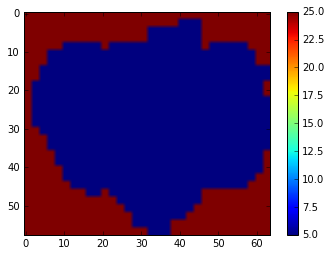

In [12]:
# -------------------------------------------------------------------------------------------------
# TURNING OFF ROUTING BY PCR IN COUPLED AREA
# -------------------------------------------------------------------------------------------------

newLDD = model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

plt.figure()
plt.imshow(newLDD)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'coupledLDD.png'), dpi=300)

In [13]:
current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
current_water_depth_1D = current_water_depth[separator_1D:]
current_water_depth_2D = current_water_depth[:separator_1D]

In [14]:
inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               landmask_pcr)

In [15]:
inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

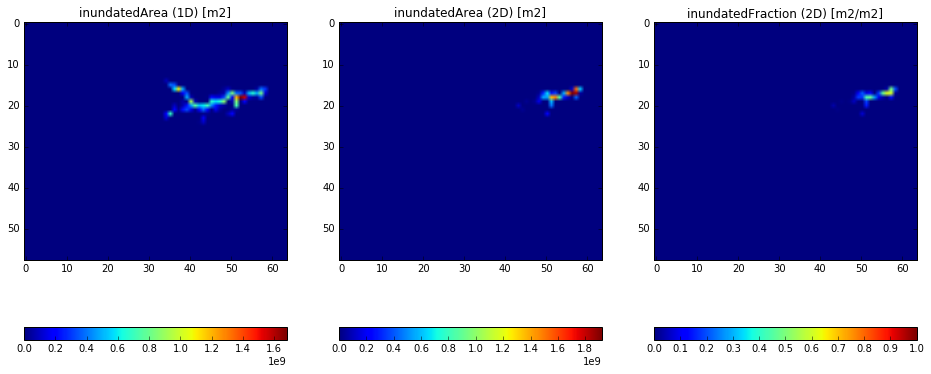

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedAreaAndFraction_HDYN_2_HLOG_BMI.png'), dpi=300)

In [17]:
current_water_volume = np.copy(hydrodynamicModel.get_var('vol1')) # all hydrodyancmi cells
current_water_volume_1D = current_water_volume[separator_1D:] # 1D channel cells
current_water_volume_2D = current_water_volume[:separator_1D] # 2D floodplain cells

In [18]:
waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI,\
        waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                          inundatedArea_HDYN1D_2_HLOG,
                                                                                          current_water_volume_1D,
                                                                                          couple_HLOG_2_HDYN,
                                                                                          coupled_HLOG_indices, 
                                                                                          landmask_pcr)

In [19]:
waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

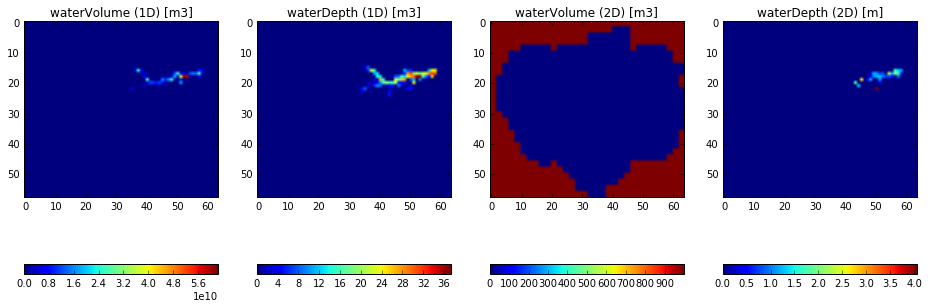

In [20]:
plt.figure(figsize=(16,8))
plt.subplot(141)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(142)
plt.title('waterDepth (1D) [m3]')
plt.imshow(waterDepth_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(143)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(144)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

In [21]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

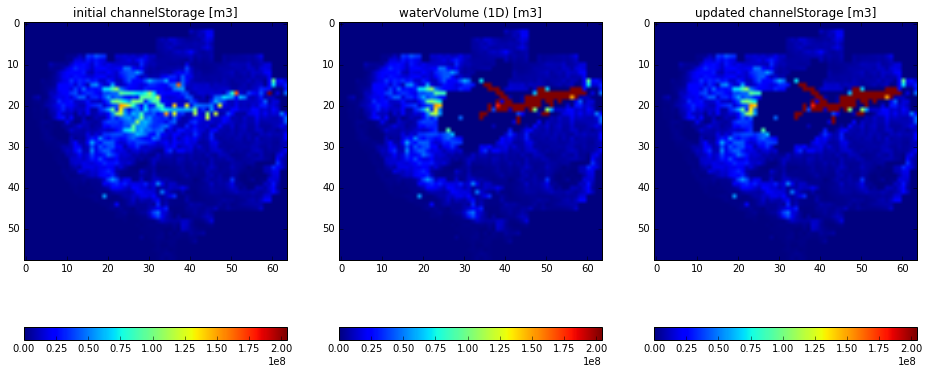

In [22]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [23]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

max fWL 4.05598413266


In [24]:
hydrologicModel.update(1)

2018-02-20 13:29:28,465 model.pcrglobwb INFO Reading forcings for time 1984-01-01
2018-02-20 13:29:29,024 model.pcrglobwb INFO Updating model for time 1984-01-01
2018-02-20 13:29:29,207 model.landSurface INFO Updating land cover: forest
2018-02-20 13:29:29,210 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/Global_CropCoefficientKc-Forest_30min.nc ; variable: kc !!!!!!
The date 1984-01-01 is NOT available. The date 2000-1-1 is used.

2018-02-20 13:29:29,391 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/interceptCapInputForest366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-01 is NOT available. The date 2000-1-1 is used.

2018-02-20 13:29:29,558 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/coverFractionInputForest366days.nc ; variable: cov

In [25]:
#waterVolume_HDYN2D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)


delta volume of all PCR cells before feedback from DFM: 3.71E+10
feedback volume from FM: 1.30E+06 
delta volume of all PCR cells after feedback from DFM: 3.71E+10
reduction by  0.0 %
delta volume for PCR cells coupled to hydrodynamic channels 2.23E+10


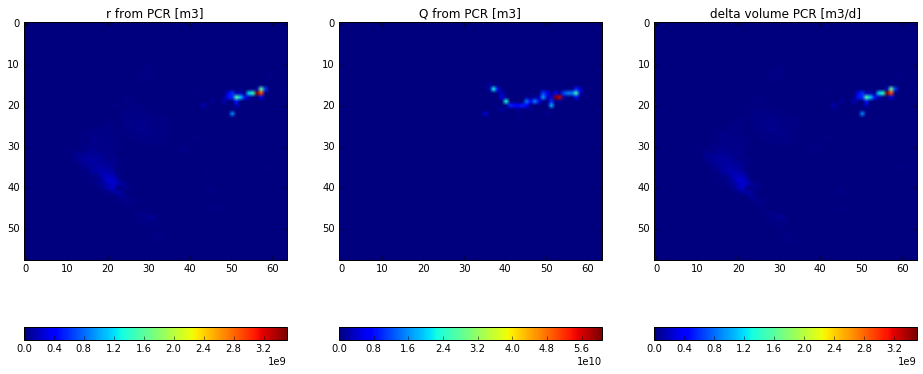

In [26]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = -999
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = -999

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [27]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

In [28]:
model_functions.updateModel(hydrodynamicModel, 
                            delta_water_DFM_1way, 
                            update_step, 
                            separator_1D, 
                            use_Fluxes, 
                            use_RFS, 
                            model_type, 
                            verbose)

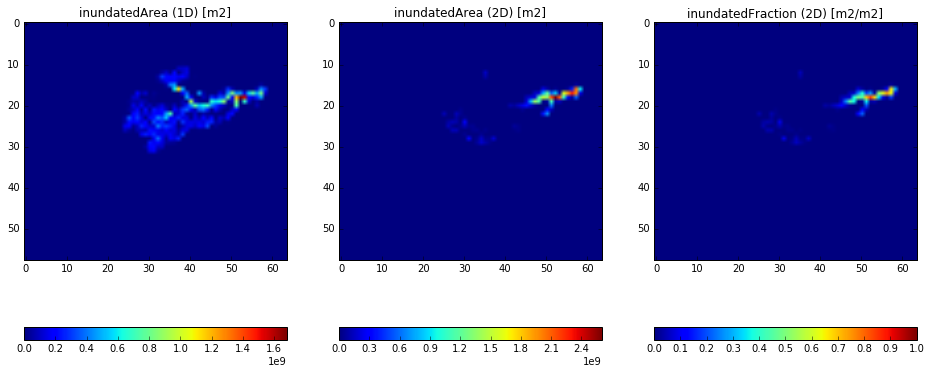

In [101]:
current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
current_water_depth_1D = current_water_depth[separator_1D:]
current_water_depth_2D = current_water_depth[:separator_1D]

inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               landmask_pcr)

inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')

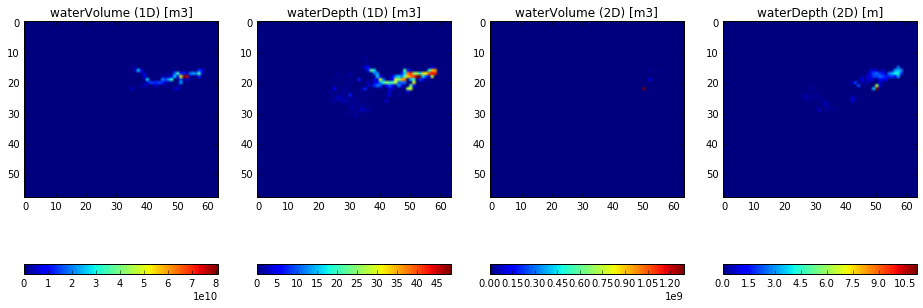

In [102]:
current_water_volume = np.copy(hydrodynamicModel.get_var('vol1'))
current_water_volume_1D = current_water_volume[separator_1D:]
current_water_volume_2D = current_water_volume[:separator_1D]

waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI,\
        waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                          inundatedArea_HDYN1D_2_HLOG,
                                                                                          current_water_volume_1D,
                                                                                          couple_HLOG_2_HDYN,
                                                                                          coupled_HLOG_indices, 
                                                                                          landmask_pcr)

waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(141)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(142)
plt.title('waterDepth (1D) [m3]')
plt.imshow(waterDepth_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(143)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(144)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
# plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

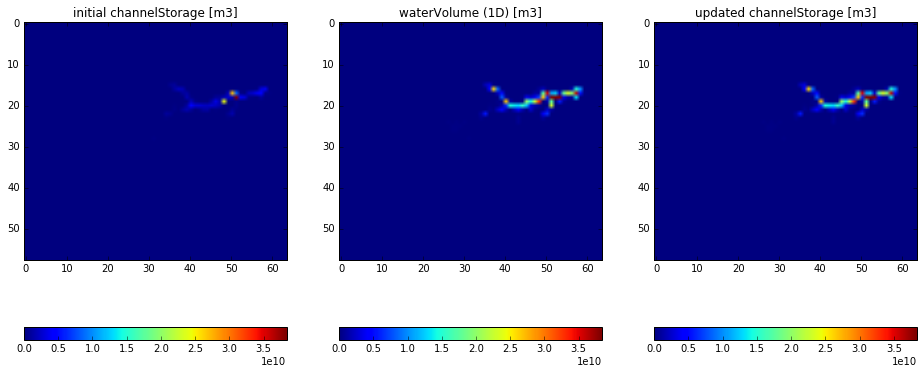

In [103]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [104]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

max fWL 11.1963404014


In [105]:
model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

hydrologicModel.update(1)

2018-02-20 13:42:16,426 model.pcrglobwb INFO Reading forcings for time 1984-01-10
2018-02-20 13:42:19,331 model.pcrglobwb INFO Updating model for time 1984-01-10
2018-02-20 13:42:19,345 model.landSurface INFO Updating land cover: forest
2018-02-20 13:42:19,348 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/Global_CropCoefficientKc-Forest_30min.nc ; variable: kc !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-20 13:42:20,357 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/interceptCapInputForest366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-20 13:42:21,349 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/coverFractionInputForest366days.nc ; variable: c

In [106]:
delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)


delta volume of all PCR cells before feedback from DFM: 9.86E+10
feedback volume from FM: 1.48E+09 
delta volume of all PCR cells after feedback from DFM: 9.71E+10
reduction by  1.5 %
delta volume for PCR cells coupled to hydrodynamic channels 9.00E+10


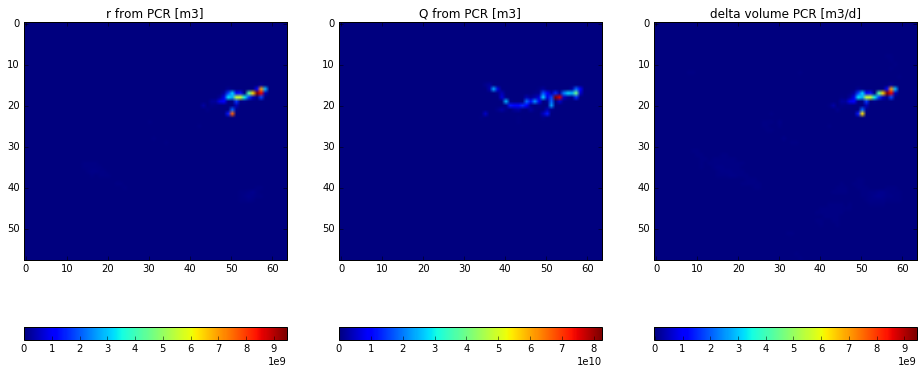

In [107]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = 0.
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = 0.

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [108]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

model_functions.updateModel(hydrodynamicModel, 
                            delta_water_DFM_1way, 
                            update_step, 
                            separator_1D, 
                            use_Fluxes, 
                            use_RFS, 
                            model_type, 
                            verbose)

In [109]:
np.max(waterDepth_HDYN1D_2_HLOG_BMI)

48.506798

In [111]:
while hydrologicModel.get_time_step() < end_time_pcr:
    
    current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
    current_water_depth_1D = current_water_depth[separator_1D:]
    current_water_depth_2D = current_water_depth[:separator_1D]

    inundatedArea_HDYN1D_2_HLOG, \
        inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                                   coupled_HLOG_indices,
                                                                                                   current_water_depth_1D,
                                                                                                   threshold_inundated_depth,
                                                                                                   cellAreaSpherical_1D,
                                                                                                   landmask_pcr)

    inundatedArea_HDYN2D_2_HLOG, \
        inundatedArea_HDYN2D_2_HLOG_BMI, \
            inundatedFraction_HDYN2D_2_HLOG, \
                inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                               coupled_HLOG_indices_2way,
                                                                                                               current_water_depth_2D,
                                                                                                               threshold_inundated_depth,
                                                                                                               cellAreaSpherical_2D,
                                                                                                               cellarea_data_pcr,
                                                                                                               landmask_pcr)
    
    current_water_volume = np.copy(hydrodynamicModel.get_var('vol1'))
    current_water_volume_1D = current_water_volume[separator_1D:]
    current_water_volume_2D = current_water_volume[:separator_1D]

    waterVolume_HDYN1D_2_HLOG,\
        waterVolume_HDYN1D_2_HLOG_BMI,\
            waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                              inundatedArea_HDYN1D_2_HLOG,
                                                                                              current_water_volume_1D,
                                                                                              couple_HLOG_2_HDYN,
                                                                                              coupled_HLOG_indices, 
                                                                                              landmask_pcr)

    waterVolume_HDYN2D_2_HLOG_BMI,\
        waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                          inundatedArea_HDYN2D_2_HLOG,
                                                                                          waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                          couple_HLOG_2_HDYN_2way,
                                                                                          coupled_HLOG_indices_2way,
                                                                                          landmask_pcr)
        
    ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

    if couple_channelStorage == False:
        waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

    model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)
    
    model_functions.updateHydrologicVariables(hydrologicModel,
                                              waterDepth_HDYN2D_2_HLOG_BMI,
                                              inundatedFraction_HDYN2D_2_HLOG_BMI)
    
    model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

    hydrologicModel.update(1)
    
    delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                    missing_value_pcr, 
                                                                                    secPerDay, 
                                                                                    coupled_HLOG_indices, 
                                                                                    cellarea_data_pcr, 
                                                                                    waterVolume_HDYN2D_2_HLOG_BMI)
    
    delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                        couple_HDYN_2_HLOG, 
                                                                                        couple_HLOG_2_HDYN,
                                                                                        coupled_HLOG_indices,
                                                                                        delta_volume_PCR_1way, 
                                                                                        cellAreaSpherical_1D, 
                                                                                        fraction_timestep, 
                                                                                        model_type, 
                                                                                        use_Fluxes)

    model_functions.updateModel(hydrodynamicModel, 
                                delta_water_DFM_1way, 
                                update_step, 
                                separator_1D, 
                                use_Fluxes, 
                                use_RFS, 
                                model_type, 
                                verbose)


hydrodynamicModel.finalize()
hydrologicModel.finalize()

NameError: name 'model_fm' is not defined